In [1]:
import pandas as pd
import numpy as np
import math
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate

# Pacotes de pré-processamento
#!pip install category-encoders
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders.james_stein import JamesSteinEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Pacotes para implementação de modelos de Machine Learning
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error


# Models testing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import lightgbm as ltb
import xgboost as xgb

# Tunning hiperparameters
import optuna
#optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# **Introduction**

Um dos problemas recorrentes enfrentado por varejistas e supermercados é o controle de estoque preciso. Caso a previsão de estoque seja a mais do que o esperado ficam presos com produtos perecíveis com excesso de estoque. Adivinhe um pouco abaixo e os itens populares esgotam rapidamente, levando à perda de receita e clientes chateados.

Com base nisto, neste projeto será desenvolvido um algoritmo de regressão de machine learning capaz de prever as vendas unitárias por cada tipo de produto para que se possa estimar com maior precisão o estoque a ser comprado. Para a avaliação do modelo será utilizado o RMSE(Root Mean Square Error) visando penalizar erros de maior magnitude em algum produto em específico, e o  RMSLE (Root Mean Square Log Error) visando punir mais os valores que eram para ser 0 do que valores mais elevados.

Para a elaboração deste projeto será realizado as seguintes etapas:
- Introduction: Visando esclarecer o objetivo do projeto, as métricas e as etapas a serem realizadas no desenvolvimento do modelo de machine learning.

- Data cleaning and preprocessing: Será feito uma pré-visualização dos dados, visando identificar e tratar dados inconsistentes e ausentes, além da criação de features simples com base nas features iniciais.

- Exploratory Data Analisys (EDA): Será realizado visualizações com o objetivo encontrar insights relevantes para o desenvolvimento do algoritmo.

- Correlation: Será analisado a correlação entre os dados visando evitar possíveis problemas de multicolinearidade.

- Model implementation: É a etapa onde será criado e avaliado o modelo de machine learning, onde também será realizado o tunning de hiperparâmetros do modelo visando melhorar o resultado do modelo, e a análise de feature importance do modelo final.

- Conclusion: Etapa onde será realizado comentários em relação o projeto realizado e também alguns levantamentos de melhorias futuras para o projeto.

# **Data cleaning and preprocessing**

In [3]:
df_train = pd.read_csv('train.csv')
df_holidays = pd.read_csv('holidays_events.csv')
df_store = pd.read_csv('stores.csv')
df_transf = pd.read_csv('transactions.csv')
df_oil = pd.read_csv('oil.csv')

In [4]:
df_train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

Observando o dataset de treino valores iguais a zero em 'sales' que pode indicar dados ausentes ou inconsistentes desta variável.

nota-se também que o dataset possui duas variáveis categóricas, a 'family' e 'store_nbr', e duas variáveis numéricas, 'sales' e 'onpromotion'.
Vamos observar mais afundo quantas categorias de 'family' e 'store_nbr' são apresentadas no dataset de teino.

In [5]:
df_train.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

Observa-se 33 categorias diferentes para 'family' e 54 categorias diferentes para 'store_nbr'.

In [6]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Inicialmente não é possível identificar nenhum dado ausente no dataset de treino.

Agora vamos analisar o dataset de holidays and events.

In [7]:
df_holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

Nota-se que todas as variáveis presentes neste dataset são categóricas. Portanto vamos verificar quantas categorias unicas existe em cada variável.

In [8]:
df_holidays.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

Observando o dataset nota-se que os dados foram coletados de 24 cidades do equador.

Pelo dataset vemos que existem 6 tipos de feriados ou eventos armazenados, 3 tipos de localidade as quais são comemorados essas datas e armazenada se elas foram transferidas ou não para outra data.

In [9]:
df_holidays.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Neste dataset também não é possível detectar a existência de dados ausentes.

In [10]:
df_store.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

Nota-se que todas as variáveis presentes neste dataset são categóricas. Portanto vamos verificar quantas categorias unicas existe em cada variável.

In [11]:
df_store.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

Vemos que existem 54 'stores', 22 'city', 16 'state', 5 'types' e 17 'cluster' diferentes neste dataframe. Nota-se que existe a mesma quantidade de store_nbr encontrada no df_train. 

Nota-se uma diferença de nomenclatura e quantidade para a variável 'city' ao encontrado em 'locale_name' no dataframe df_holiday.

In [12]:
df_store.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Neste dataset também não é possível detectar a existência de dados ausentes.

In [13]:
df_transf.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

Examinando o dataset de tranferências nota-se somente duas variáveis, sendo uma categórica já identificada no dataset de treino e uma numérica, representando quantas vendas foram realizadas naquele dia pelo store.

In [14]:
df_transf.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

também não é possível identificar dados ausentes neste dataset

In [15]:
df_oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

O dataset oil é composto unicamente pelo valor de oil naquele dia.

In [16]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [17]:
df_oil.shape

(1218, 2)

Nota-se que neste dataset é possível identificar uma pequena quantidade de dados ausentes em relação a quantidade de dados. Para realizar o tratamento destes dados será feito inicialmente uma visualização dos dados em relação a média visando identificar se a mesma é representativa.

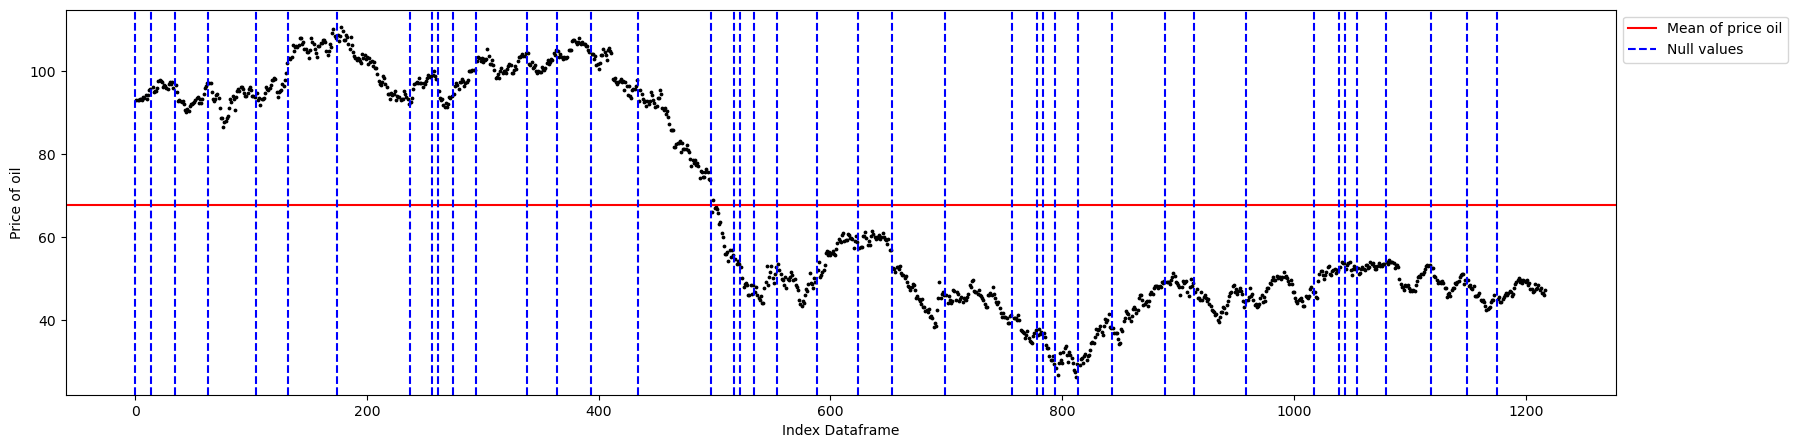

In [18]:
mean = df_oil['dcoilwtico'].mean()
null_idx = df_oil[df_oil['dcoilwtico'].isnull()].index
plt.figure(figsize = (20, 5))
plt.scatter(x = df_oil.index,y = df_oil['dcoilwtico'], s=3, color = 'k')
plt.xlabel('Index Dataframe')
plt.ylabel('Price of oil')
plt.axhline(y = mean, color = 'r', linestyle = '-', label = 'Mean of price oil')
for i in range(len(null_idx)-2):
    plt.axvline(x = null_idx[i],linestyle = '--', color = 'b')
    
plt.axvline(x = null_idx[-1], color = 'b',linestyle = '--', label = 'Null values')    
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

Nota-se que os dados ausentes ocorrem geralmente de maneira espaçada e que a média não seria um valor representativo como método de imputamento. Para realizar a substituição desses dados será feito a média entre os dois valores anteriores e posteriores ao dado ausente para garantir uma maior exatidão.

Como neste caso o primeiro valor já é um dado ausente será feito a média dos três valores posteriores

In [19]:
df_oil.iloc[null_idx[0],1] = df_oil.iloc[null_idx[0]+1:null_idx[0]+4,1].mean()

for i in range(1,len(null_idx)-1):
    df_oil.iloc[null_idx[i],1] = df_oil.iloc[null_idx[i]-2:null_idx[i]+3,1].mean()

# **EDA (Exploratory Data Analysis)**

Para uma melhor visualização e manipulação dos dados será feito a união dos dataframes: df_train, df_holidays,df_store e df_oil.

Inicialmente será feito uma verificação entre os dataframes df_holidays e df_store para identificar se as variáveis 'locale_name' e 'city' possuem os mesmos locais para fazer um alinhamento destes datasets para depois alinha-los com o dataset df_train.

In [20]:
df_holidays['locale_name'].unique() 

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [21]:
df_store['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

Existem três cidades que estão presentes no dataframe do store que não estão presentes no dataframe holidays, que são: Playas, Daule, Babahoyo. Provavelmente cidades que não possuem feriados locais e por isto não aparecem no dataset holidays.

Existem cinco locais que estão presentes no dataframe holidays que não estão no dataframe do store, que são: Cotopaxi, Santo Domingo de los Tsachilas, Imbabura, Ecuador, Santa Elena.
Excluindo o 'Ecuador' encontrado, todos são feriados locais de cidades que podem ou não ter abastecimento de uma ou varias lojas de outras cidades catalogadas no dataset store. 

Neste caso o alinhamento entre estes dois dataset não é possível. Portanto será feito o alinhamento do dataset de holidays com o dataset de treino por meio da data e o alinhamento do dataset store com o dataset de treino por meio do 'store_nbr'. O dataset oil será alinhado pela data também com o dataset de treino.

Após isso, será realizado a criação de features complementares da data, fazendo a separação do ano, mês, dia do mês, semana do mês e dia da semana. Como foi informado no início do projeto o dia do pagamento ocorre no dia 15 e no final de cada mês, portanto será criado uma feature para armazenar esta informação, onde o dia do pagamento será '1' e o outros dias serão '0'.

In [22]:
df_oil.rename(columns={"dcoilwtico": "oil_price"},inplace = True)
df_store.rename(columns={"city": "city_store","state":"state_store","type":"type_store","cluster":"cluster_store"},inplace = True)
df_holidays.rename(columns={"type":"type_day","locale":"type_holiday"},inplace = True)
train_merged = pd.merge(df_train, df_store,how='left', on ='store_nbr')
train_merged = pd.merge(train_merged, df_holidays,how='left', on ='date')
train_merged = pd.merge(train_merged, df_oil,how='left', on ='date')
train_merged = pd.merge(train_merged, df_transf,how='left', on =['date','store_nbr'])

In [23]:
def extra_features(df):
    df['date'] = pd.to_datetime(df['date']) 
    df['day'] = df['date'].dt.day
    df['day_week'] = df['date'].dt.weekday
    df['weekmonth'] = (df['day'] - 1) // 7 + 1
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['payment'] = df['date'].agg(lambda x: 1 if x.day==15 else 1 if x == x.days_in_month else 0)
    return df

In [24]:
train_merged = extra_features(train_merged)

In [25]:
train_merged.head()

id       date  store_nbr      family  sales  onpromotion city_store  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0      Quito   
1   1 2013-01-01          1   BABY CARE    0.0            0      Quito   
2   2 2013-01-01          1      BEAUTY    0.0            0      Quito   
3   3 2013-01-01          1   BEVERAGES    0.0            0      Quito   
4   4 2013-01-01          1       BOOKS    0.0            0      Quito   

  state_store type_store  cluster_store  ...         description transferred  \
0   Pichincha          D             13  ...  Primer dia del ano       False   
1   Pichincha          D             13  ...  Primer dia del ano       False   
2   Pichincha          D             13  ...  Primer dia del ano       False   
3   Pichincha          D             13  ...  Primer dia del ano       False   
4   Pichincha          D             13  ...  Primer dia del ano       False   

   oil_price transactions day  day_week  weekmonth  month  year  payment  
0  93.076667          NaN   1         1          1      1  2013        0  
1  93.076667          NaN   1         1          1      1  2013        0  
2  93.076667          NaN   1         1          1      1  2013        0  
3  93.076667          NaN   1         1          1      1  2013        0  
4  93.076667          NaN   1         1          1      1  2013        0  

[5 rows x 23 columns]

Após a união dos datasets é necessário verificar se ocorreu a geração de dados ausentes durantes as uniões.

In [26]:
train_merged.isnull().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city_store             0
state_store            0
type_store             0
cluster_store          0
type_day         2551824
type_holiday     2551824
locale_name      2551824
description      2551824
transferred      2551824
oil_price         880308
transactions      249117
day                    0
day_week               0
weekmonth              0
month                  0
year                   0
payment                0
dtype: int64

Nota-se a criação de dados ausentes nas seguintes variáves:
- 'type_day': Como no dataset holiday só constava dias de feriados os outros dias que estão presentes no dataset de treino seriam dias normais. Neste caso será feita uma substituição desses dados ausentes pela categoria 'Normal'.
- 'type_holiday': Como no dataset holiday só constava dias de feriados os outros dias que estão presentes no dataset de treino seriam dias normais. Neste caso será feita uma substituição desses dados ausentes pela categoria 'None'.
- 'locale_name': Como no dataset holiday só constava dias de feriados os outros dias que estão presentes no dataset de treino seriam dias normais. Neste caso será feita uma substituição desses dados ausentes pela categoria 'None'.
- 'description': No dataset holiday ele serve para descrever qual é o tipo de feriado. Neste caso será feita uma substituição desses dados ausentes pela categoria 'Normal day'.
- 'transferred': Como no dataset holiday só constava dias de feriados os outros dias que estão presentes no dataset de treino seriam dias normais. Neste caso será feita uma substituição desses dados ausentes pela categoria 'None'.
- 'oil_price': Como no dataset oil só consta os dias em que ocorreu variação de preço do petróleo os outros dias presentes no dataset de treino ficariam com dados ausentes. Neste caso será feito a repetição do ultimo valor de preço do petróleo disponível.
- 'Transactions': Como existem dias em que não ocorreram transações de vendas, estes dados aparecem ausentes no dataset, portanto eles serão preenchidos com 0.

In [27]:
train_merged['type_day'].replace(to_replace=np.nan, value='Normal', inplace=True)
train_merged['type_holiday'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['locale_name'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['description'].replace(to_replace=np.nan, value='Normal day', inplace=True)
train_merged['transferred'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['transactions'].replace(to_replace=np.nan, value= 0, inplace=True)

train_merged['oil_price'].fillna(method="ffill", inplace = True)


In [28]:
train_merged.isnull().sum()

id               0
date             0
store_nbr        0
family           0
sales            0
onpromotion      0
city_store       0
state_store      0
type_store       0
cluster_store    0
type_day         0
type_holiday     0
locale_name      0
description      0
transferred      0
oil_price        0
transactions     0
day              0
day_week         0
weekmonth        0
month            0
year             0
payment          0
dtype: int64

Agora com os dados limpos, será feito a visualização dos dados visando responder as seguintes questões:

- Como é a distribuição de vendas no decorrer dos anos?
- O feriado afeta a quantidade de vendas de alguma família de produto?

- Existe uma diferença de demanda nos dias de fim de semana para os outros dias?

- Qual é a distribuição de vendas para cada store?

-  Como é a distribuição de promoções para cada família de produto?

## Question 1

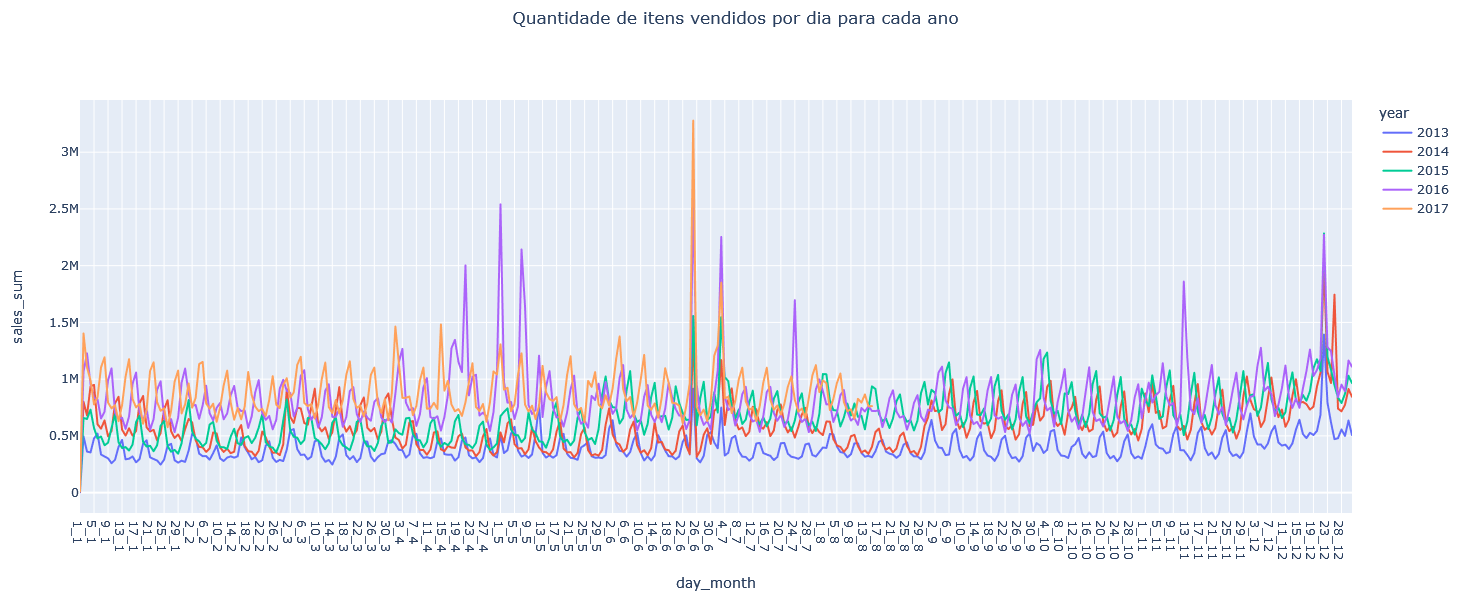

In [29]:
year_sales = train_merged.groupby(['year','date']).agg(sales_sum=('sales','sum'))
year_sales.reset_index(inplace = True)
year_sales['day'] = year_sales['date'].dt.day
year_sales['month'] = year_sales['date'].dt.month
year_sales['day_month'] = year_sales['day'].apply(str) +'_'+year_sales['month'].apply(str) 

idx = year_sales[year_sales['day_month'] == '29_2'].index # removendo dia existente no ano bissexto para melhor vizualização no gráfico
year_sales.drop(index = idx, inplace = True)

fig = px.line(year_sales ,x = 'day_month', y='sales_sum',color = 'year', title='Quantidade de itens vendidos por dia para cada ano',height=600)
fig.update_layout(title={'y':0.98,'x':0.5})
fig.show()

Pelo gráfico nota-se:
- Uma tendência de crescimento de vendas com o passar dos anos.
- Uma baixa de vendas no 1 dia do ano, decorrente do feriado de ano novo, que provavelmente ocorreu o fechamento das lojas.
- A existência de picos de vendas no ano de 2016 nos dias 21_4, 1_5, 7_5. Esses picos de venda podem ter ocorrido porque são dias posteriores ao terremoto de Manabi.
- Nota-se que no dia 25_6 ocorre um pico elevado de produtos nos anos de 2016 e 2017, devido a comemoração do feriado regional de 'Provincializacion de Imbabura' e outros feriados de idependência local.
- No dia 3_7 existe outro pico de vendas, que é uma data de comemoração de feriado nas cidades de 'El carmen' e 'Santo Domingo'.
- Nos dias 24_7 e 12_11 do ano de 2016 ocorreram picos de vendas porém foi devido a comemorações de eventos que não ocorreram nos outros anos, como 'Traslado Fundacion de Guayaquil' em 07/24/2016 e 'Recupero Puente Dia de Difuntos' em 11/12/2016.
- No ano de 2014 ocorreu uma baixa de vendas no período do mês de Agosto.
- Ocorrem picos de vendas próximos a data do dia 25_12 por serem datas próximas ao feriado do natal. Em 2014 ocorreu um pico de venda também no dia 26_12, devido a comemoração 'Puente Navidad' que não ocorreu nos outros anos.
- Ocorrem máximas de compras próximos aos dias 15 e ao fim de cada mês, que são os dias em que ocorre o pagamento do setor público.


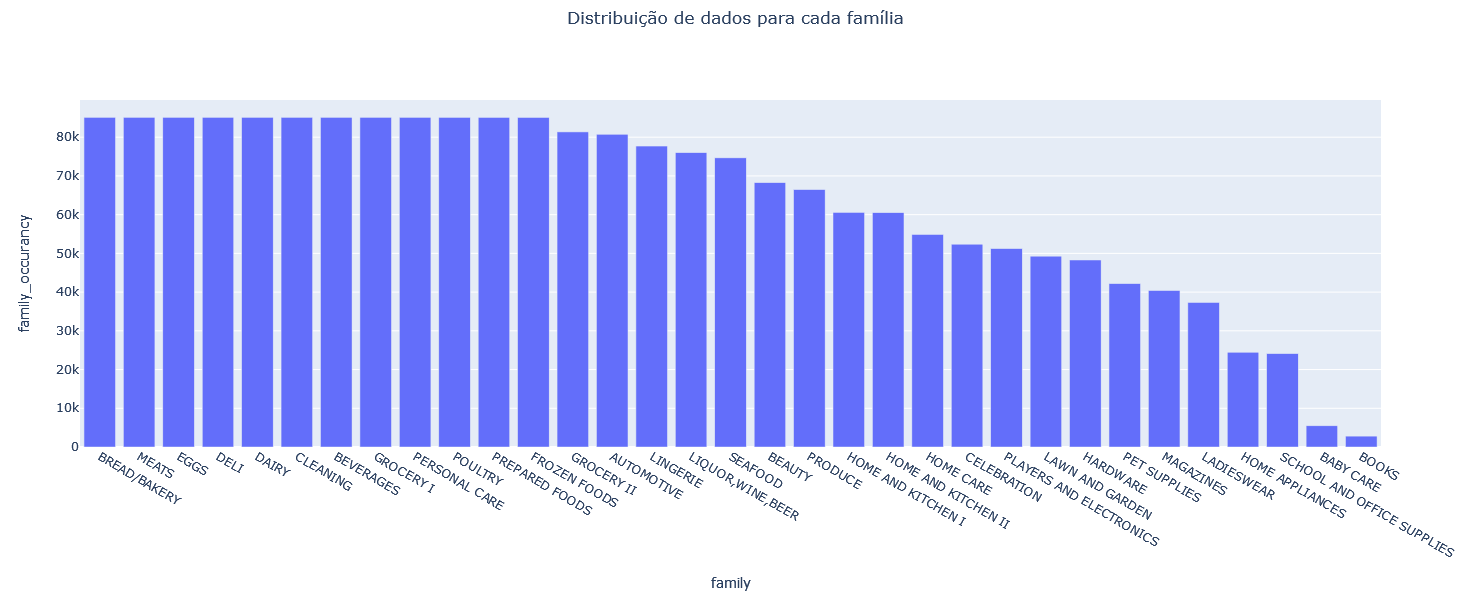

In [30]:
sales_family = train_merged.groupby('family').agg(family_occurancy = ('sales',lambda x: np.sum(x>0)))
sales_family.reset_index(inplace = True)

fig = px.bar(sales_family, x = 'family', y = 'family_occurancy',title = 'Distribuição de dados para cada família',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Pelo gráfico nota-se que metade das classes de família com maior valor de ocorrência possuem valores parecidos.

Nota-se também:
- Duas classes com valores muito baixos de ocorrência: 'BABY CARE' e 'BOOKS'. 
- As classes 'SCHOOL AND OFFICE SUPPLIES', 'HOME APPLIANCES', 'LADIESWEAR', 'MAGAZINES' e 'PET SUPPLIES' tem menos da metade da ocorrência dos produtos mais vendidos. 
- Nota-se que a maior parte dos itens de maior ocorrência são famílias de produtos destinados à alimentação. 

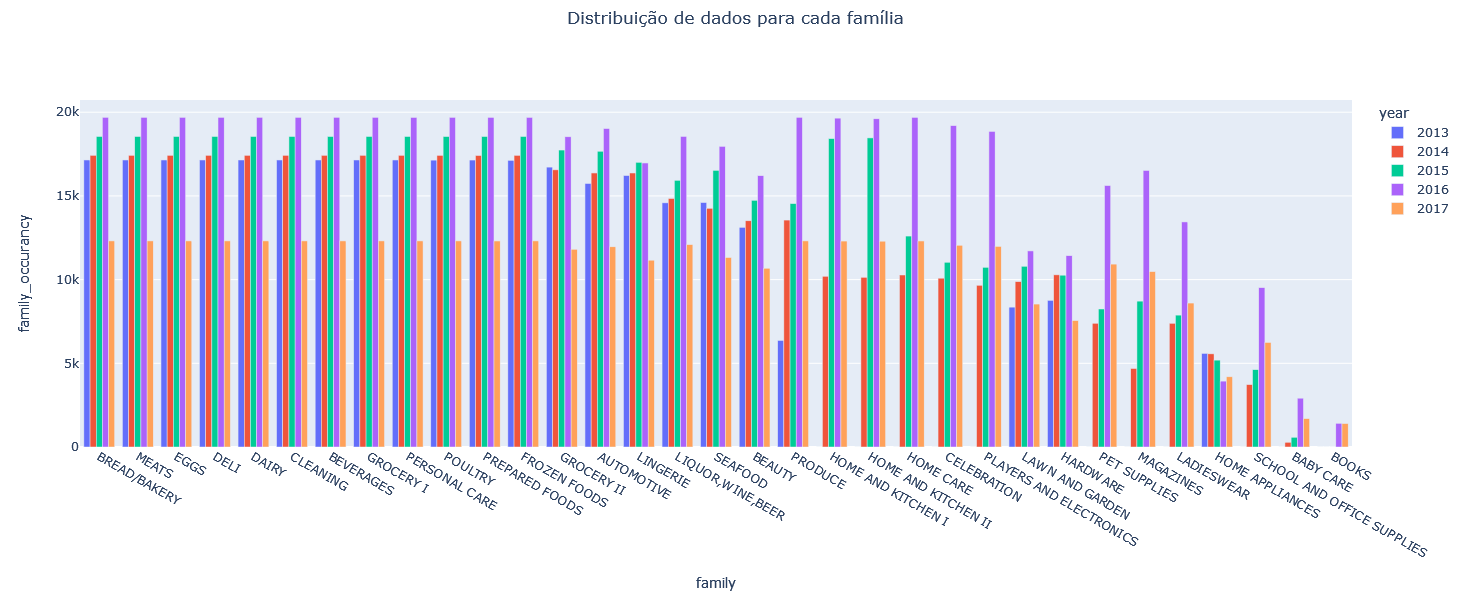

In [31]:
sales_family = train_merged.groupby(['family','year']).agg(family_occurancy = ('sales',lambda x: np.sum(x>0)))
sales_family.reset_index(inplace = True)
sales_family['year'] = sales_family['year'].replace([2013,2014,2015,2016,2017],['2013','2014','2015','2016','2017'])


fig = px.bar(sales_family, x = 'family', y = 'family_occurancy',color = 'year',barmode = 'group', title = 'Distribuição de dados para cada família',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Pelo gráfico temos que:
- Os produtos 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME CARE', ' CELEBRATION', 'PET SUPPLIES', 'MAGAZINES', 'LADIESWEAR', 'SCHOOL AND OFFICE SUPPLIES' começaram a ser vendidos em 2014.
- Os produtos da família 'BOOKS' só começaram a ser vendidos em 2016, que pode ser o motivo da sua pouca presença de dados.

Com isto é possivel concluir que:
- Ocorre um efeito cíclico de vendas em dias normais, tendo altas em dias próximos e posteriores ao recebimento do pagamento. Portanto caso seja criado uma feature com base neste aspecto pode aumentar a capacidade preditiva do modelo.
- Ocorreu vendas anormais nos dias 21_4,1_5,7_5,24_7,12_11 no ano de 2016 decorrentes de desastres naturais e feriados únicos. Como são eventos unícos podem acabar afetando de maneira positiva o modelo, visto que ele pode assimilar que eventos 'novos' podem acabar gerando picos de vendas.
- Ocorre pico de vendas em feriados nacionais e regionais, mostrando que a feature 'type_holiday' pode ter um impacto positivo no desenvolvimento do modelo.
- Existe a baixa ocorrência de algumas famílias, que podem apresentar um desempenho menor na previsão dessas classes.

## Question 2

Para verificar se o feriado afeta ou não de maneira significativa as vendas de uma determinada família de produtos será feito o comparativo entre a média de vendas de cada família por tipo de dia.

In [32]:
# Tirando dados de vendas iguais a zeros para não afetar a média.
aux = train_merged[train_merged['sales']>0]

# Evitar dados que não são 'feriados' propriamente ditos.
aux = aux[aux['type_day'] !='Event'] 
aux = aux[aux['type_day'] !='Work Day'] 

aux1 = aux.groupby(['type_holiday','family']).agg(sales_mean = ('sales','mean'))
holiday_sales = pd.DataFrame(aux1).reset_index()

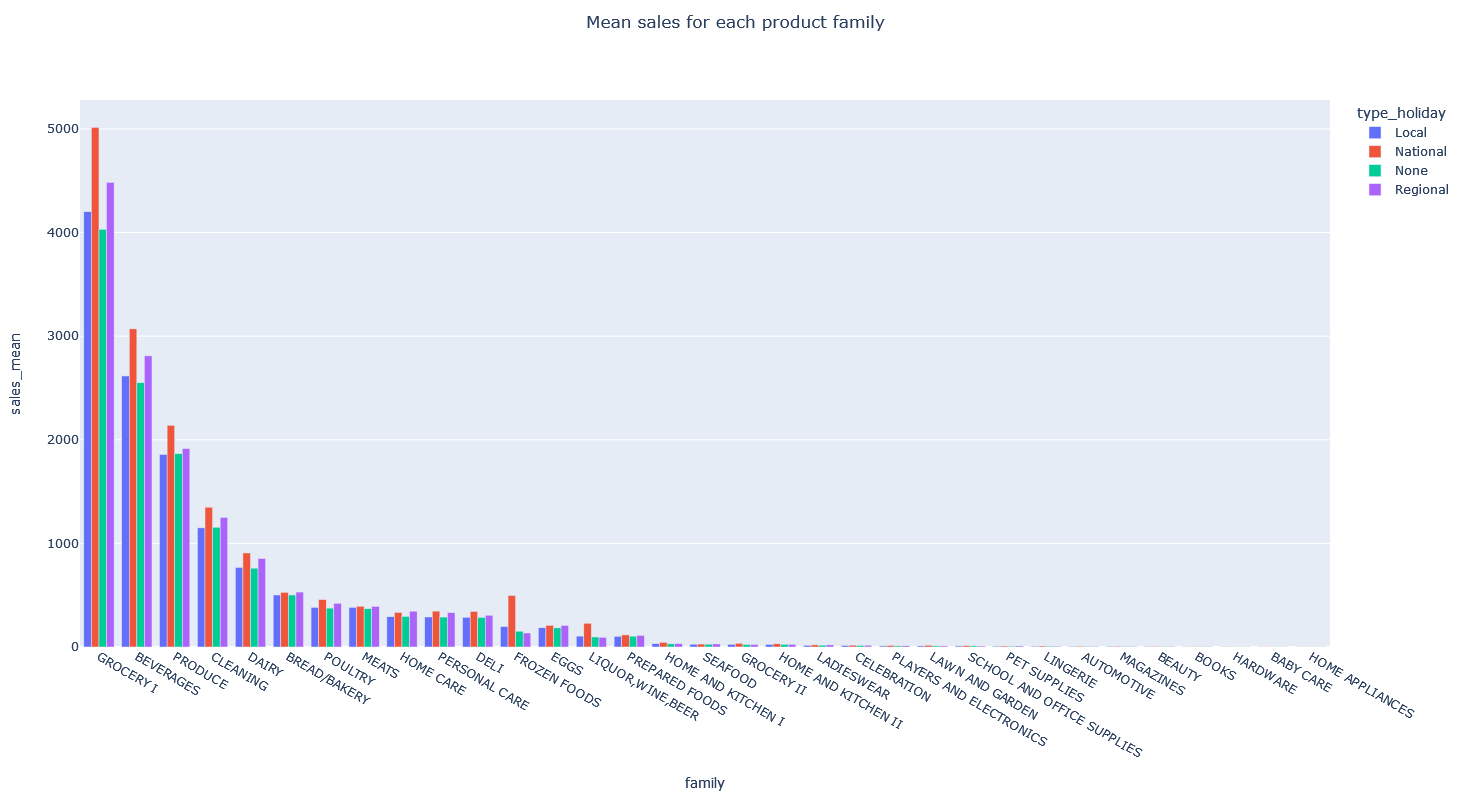

In [33]:
fig = px.bar(holiday_sales, x = 'family', y = 'sales_mean',title = 'Mean sales for each product family', color ='type_holiday',barmode ='group', height=800)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Nota-se pelo gráfico que os produtos com média acima de 600 tem-se:
- Os feirados do tipo 'National', 'Regional' acabam tendo uma média de vendas maiores que um dia normal. 
- Nota-se que a média do feriado 'National' é maior do que a média 'Regional'.

Para produtos com média menor que 600 e acima de 40 temos:
 - O tipo de feriado 'Local' apresenta ter um valor de média similar ao de um dia normal, com exceção de 'FROZEN FOODS' onde neste caso a média do feriado é relativamente maior.
 - O tipo de feriado 'National' apresenta média similar a um dia normal para os produtos: 'BREAD/BAKERY', 'MEATS', 'EGGS', 'PREPARED FOODS'. Para os demais produtos a média 'National' é maior do que um dia normal.
 - O tipo de feriado 'Regional' apresenta média maior que um dia normal para a maioria dos produtos, exceto 'MEATS', 'EGGS' e 'PREPARED FOODS'.
 
 Para produtos com média de vendas menor que 40 não é possível vizualizar adequadamente neste gráfico, portanto será feito um gráfico a parte para sua vizualização.

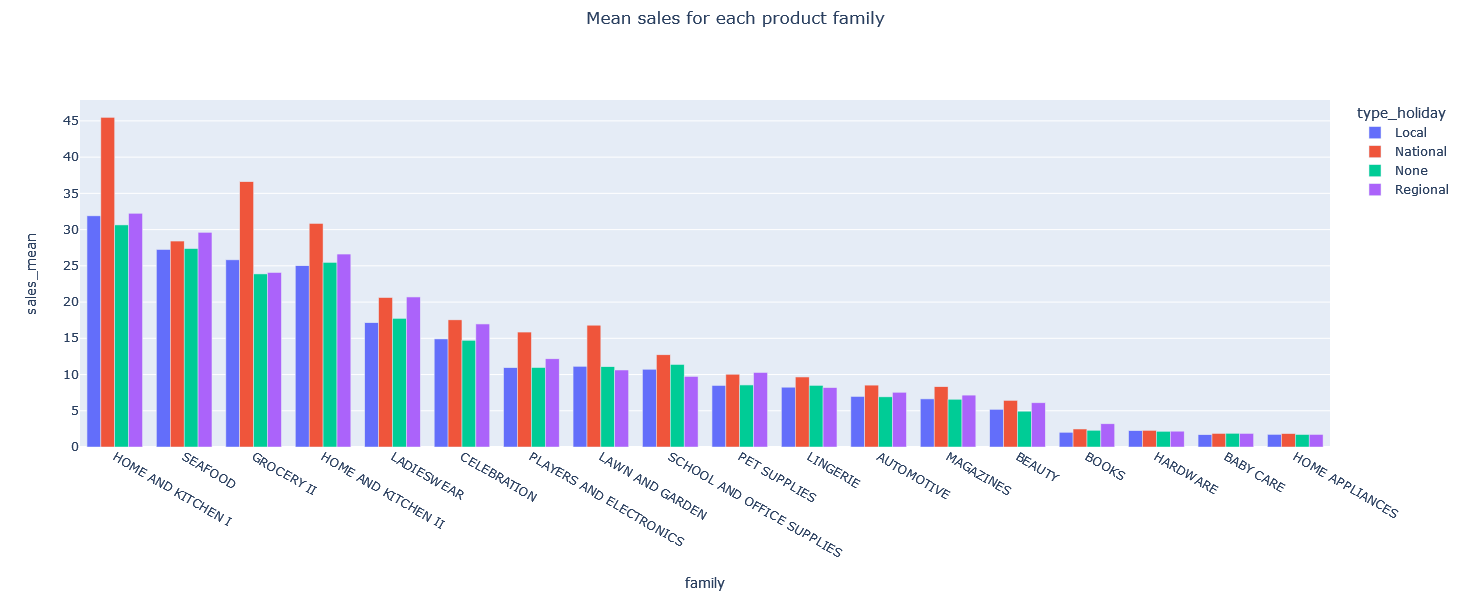

In [34]:
aux = holiday_sales[holiday_sales['sales_mean']<50]
fig = px.bar(aux, x = 'family', y = 'sales_mean',title = 'Mean sales for each product family', color ='type_holiday',barmode ='group', height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

No gráfico é possível observar que mesmo para produtos com média de vendas menores o tipo de feriado 'National e 'Regional' acabam tendo um valor de média maior que um dia normal.

Novamente ocorre médias similares entre os feriados 'Local' e um dia normal.

Mas para validar esta afirmação de que os feriados têm uma média maior do que os dias normais será realizado um teste de hipótese para cada família, pois estas médias visualizadas podem ter sofrido efeitos de outiliers dos dado de venda.

Inicialmente para realizar o teste de hipótese é necessário verificar se a distribuição de vendas em cada um desses tipos de dias possui um formato Gaussiano. Para isto será realizado o teste de normalidade para cada uma das famílias separando os dados em cada tipo de feriado.
- Neste teste de normalidade será atribuido um nível de significãncia de 0.05.
- A hipótese nula é que a distribuição dos dados é 'normal.
- A hipótese alternativa é que a distribuição dos dados 'não é normal'.

In [35]:
df_aux = train_merged[train_merged['sales']>0]
df_aux = df_aux[df_aux['type_day'] !='Event'] 
df_aux = df_aux[df_aux['type_day'] !='Work Day'] 

family_list = train_merged['family'].unique()
holiday_list = train_merged['type_holiday'].unique()

result_test = pd.DataFrame(np.zeros([len(family_list),len(holiday_list)]), columns = holiday_list, index = family_list)

for i in range(0,len(family_list)):
    df_val = df_aux[df_aux['family'] == family_list[i]]
    for j in range(0,len(holiday_list)):
        fillter = df_val['type_holiday'] == holiday_list[j]
        k2, p = stats.normaltest(df_val[fillter].sales)
        
        if p<0.05:
            result_test.iloc[i,j] = 'Non-normal dist'
        else:
            result_test.iloc[i,j] = 'Normal dist'
        
result_test

National             None            Local  \
AUTOMOTIVE                  Non-normal dist  Non-normal dist  Non-normal dist   
BABY CARE                   Non-normal dist  Non-normal dist  Non-normal dist   
BEAUTY                      Non-normal dist  Non-normal dist  Non-normal dist   
BEVERAGES                   Non-normal dist  Non-normal dist  Non-normal dist   
BOOKS                       Non-normal dist  Non-normal dist  Non-normal dist   
BREAD/BAKERY                Non-normal dist  Non-normal dist  Non-normal dist   
CELEBRATION                 Non-normal dist  Non-normal dist  Non-normal dist   
CLEANING                    Non-normal dist  Non-normal dist  Non-normal dist   
DAIRY                       Non-normal dist  Non-normal dist  Non-normal dist   
DELI                        Non-normal dist  Non-normal dist  Non-normal dist   
EGGS                        Non-normal dist  Non-normal dist  Non-normal dist   
FROZEN FOODS                Non-normal dist  Non-normal dist  Non-normal dist   
GROCERY I                   Non-normal dist  Non-normal dist  Non-normal dist   
GROCERY II                  Non-normal dist  Non-normal dist  Non-normal dist   
HARDWARE                    Non-normal dist  Non-normal dist  Non-normal dist   
HOME AND KITCHEN I          Non-normal dist  Non-normal dist  Non-normal dist   
HOME AND KITCHEN II         Non-normal dist  Non-normal dist  Non-normal dist   
HOME APPLIANCES             Non-normal dist  Non-normal dist  Non-normal dist   
HOME CARE                   Non-normal dist  Non-normal dist  Non-normal dist   
LADIESWEAR                  Non-normal dist  Non-normal dist  Non-normal dist   
LAWN AND GARDEN             Non-normal dist  Non-normal dist  Non-normal dist   
LINGERIE                    Non-normal dist  Non-normal dist  Non-normal dist   
LIQUOR,WINE,BEER            Non-normal dist  Non-normal dist  Non-normal dist   
MAGAZINES                   Non-normal dist  Non-normal dist  Non-normal dist   
MEATS                       Non-normal dist  Non-normal dist  Non-normal dist   
PERSONAL CARE               Non-normal dist  Non-normal dist  Non-normal dist   
PET SUPPLIES                Non-normal dist  Non-normal dist  Non-normal dist   
PLAYERS AND ELECTRONICS     Non-normal dist  Non-normal dist  Non-normal dist   
POULTRY                     Non-normal dist  Non-normal dist  Non-normal dist   
PREPARED FOODS              Non-normal dist  Non-normal dist  Non-normal dist   
PRODUCE                     Non-normal dist  Non-normal dist  Non-normal dist   
SCHOOL AND OFFICE SUPPLIES  Non-normal dist  Non-normal dist  Non-normal dist   
SEAFOOD                     Non-normal dist  Non-normal dist  Non-normal dist   

                                   Regional  
AUTOMOTIVE                  Non-normal dist  
BABY CARE                   Non-normal dist  
BEAUTY                      Non-normal dist  
BEVERAGES                   Non-normal dist  
BOOKS                       Non-normal dist  
BREAD/BAKERY                Non-normal dist  
CELEBRATION                 Non-normal dist  
CLEANING                    Non-normal dist  
DAIRY                       Non-normal dist  
DELI                        Non-normal dist  
EGGS                        Non-normal dist  
FROZEN FOODS                Non-normal dist  
GROCERY I                   Non-normal dist  
GROCERY II                  Non-normal dist  
HARDWARE                    Non-normal dist  
HOME AND KITCHEN I          Non-normal dist  
HOME AND KITCHEN II         Non-normal dist  
HOME APPLIANCES             Non-normal dist  
HOME CARE                   Non-normal dist  
LADIESWEAR                  Non-normal dist  
LAWN AND GARDEN             Non-normal dist  
LINGERIE                    Non-normal dist  
LIQUOR,WINE,BEER            Non-normal dist  
MAGAZINES                   Non-normal dist  
MEATS                       Non-normal dist  
PERSONAL CARE               Non-normal dist  
PET SUPPLIES                Non-normal

Pela tabela vemos que nenhum destes grupos apresenta uma distribuição normal, portanto será aplicado a transformação de Box-Cox para transformá-los em uma distribuição normal. Após a transformação é necessário realizar a mesma verificação de distribuição normal para validar a transformação.

In [36]:
result_test = pd.DataFrame(np.zeros([len(family_list),len(holiday_list)]), columns = holiday_list, index = family_list)
df_val_t = aux.copy()
for i in range(0,len(family_list)):
    df_val = df_aux[df_aux['family'] == family_list[i]]
    for j in range(0,len(holiday_list)):
        fillter = df_val['type_holiday'] == holiday_list[j]
        x,_ = stats.boxcox(df_val[fillter].sales)
        k2, p = stats.normaltest(x)
        
        if p<0.05:
            result_test.iloc[i,j] = 'Non-normal dist'
        else:
            result_test.iloc[i,j] = 'Normal dist'
        
result_test

National             None            Local  \
AUTOMOTIVE                  Non-normal dist  Non-normal dist  Non-normal dist   
BABY CARE                   Non-normal dist  Non-normal dist  Non-normal dist   
BEAUTY                      Non-normal dist  Non-normal dist  Non-normal dist   
BEVERAGES                   Non-normal dist  Non-normal dist      Normal dist   
BOOKS                       Non-normal dist  Non-normal dist  Non-normal dist   
BREAD/BAKERY                Non-normal dist  Non-normal dist  Non-normal dist   
CELEBRATION                 Non-normal dist  Non-normal dist      Normal dist   
CLEANING                        Normal dist  Non-normal dist      Normal dist   
DAIRY                       Non-normal dist  Non-normal dist      Normal dist   
DELI                            Normal dist  Non-normal dist  Non-normal dist   
EGGS                            Normal dist  Non-normal dist      Normal dist   
FROZEN FOODS                    Normal dist  Non-normal dist  Non-normal dist   
GROCERY I                       Normal dist  Non-normal dist      Normal dist   
GROCERY II                  Non-normal dist  Non-normal dist  Non-normal dist   
HARDWARE                    Non-normal dist  Non-normal dist  Non-normal dist   
HOME AND KITCHEN I          Non-normal dist  Non-normal dist  Non-normal dist   
HOME AND KITCHEN II         Non-normal dist  Non-normal dist  Non-normal dist   
HOME APPLIANCES             Non-normal dist  Non-normal dist  Non-normal dist   
HOME CARE                       Normal dist  Non-normal dist  Non-normal dist   
LADIESWEAR                  Non-normal dist  Non-normal dist  Non-normal dist   
LAWN AND GARDEN                 Normal dist  Non-normal dist  Non-normal dist   
LINGERIE                    Non-normal dist  Non-normal dist  Non-normal dist   
LIQUOR,WINE,BEER                Normal dist      Normal dist      Normal dist   
MAGAZINES                   Non-normal dist  Non-normal dist  Non-normal dist   
MEATS                       Non-normal dist  Non-normal dist      Normal dist   
PERSONAL CARE                   Normal dist  Non-normal dist  Non-normal dist   
PET SUPPLIES                Non-normal dist  Non-normal dist  Non-normal dist   
PLAYERS AND ELECTRONICS     Non-normal dist  Non-normal dist  Non-normal dist   
POULTRY                     Non-normal dist  Non-normal dist  Non-normal dist   
PREPARED FOODS              Non-normal dist  Non-normal dist      Normal dist   
PRODUCE                     Non-normal dist  Non-normal dist  Non-normal dist   
SCHOOL AND OFFICE SUPPLIES  Non-normal dist  Non-normal dist  Non-normal dist   
SEAFOOD                     Non-normal dist  Non-normal dist  Non-normal dist   

                                   Regional  
AUTOMOTIVE                  Non-normal dist  
BABY CARE                   Non-normal dist  
BEAUTY                      Non-normal dist  
BEVERAGES                       Normal dist  
BOOKS                       Non-normal dist  
BREAD/BAKERY                Non-normal dist  
CELEBRATION                     Normal dist  
CLEANING                        Normal dist  
DAIRY                           Normal dist  
DELI                            Normal dist  
EGGS                            Normal dist  
FROZEN FOODS                Non-normal dist  
GROCERY I                       Normal dist  
GROCERY II                  Non-normal dist  
HARDWARE                    Non-normal dist  
HOME AND KITCHEN I              Normal dist  
HOME AND KITCHEN II             Normal dist  
HOME APPLIANCES             Non-normal dist  
HOME CARE                       Normal dist  
LADIESWEAR                      Normal dist  
LAWN AND GARDEN             Non-normal dist  
LINGERIE                    Non-normal dist  
LIQUOR,WINE,BEER                Normal dist  
MAGAZINES                   Non-normal dist  
MEATS                       Non-normal dist  
PERSONAL CARE                   Normal dist  
PET SUPPLIES                Non-normal

Pela tabela vemos que em maioria não foi possível transformar a maioria dos grupos em distribuições normais. Neste caso terá que ser aplicado um teste 'não paramétrico'. Podemos optar pelo teste de 'Kruskall-Wallis' caso fosse necessário comprar os 4 grupos de dias ao mesmo tempo, porém ele não nos daria a informação que queremos: se a média dos dias normais é menor do que a dos outros tipos de feriados. 

Portanto será realizado o teste de 'Mann-Whitney' comparando os dados de dias normais com cada tipo de feriado (National, Local e Regional).
Neste caso temos:
- Neste teste de normalidade será atribuido um nível de significãncia de 0.05.
- A hipótese nula é que a média de vendas em dias normais é maior ou igual a média do feriado avaliado.
- A hipótese alternativa é que a  média de vendas em dias normais é menor a média do feriado avaliado.

Portanto será avaliado se a hipótese nula é aceita ou rejeitada.

In [37]:
test_list = ['None-Regional','None-National','None_Local']
MW_result = pd.DataFrame(np.zeros([len(family_list),len(test_list)]), columns = test_list, index = family_list)
holiday_list = ['Regional','National','Local']

for i in range(0,len(family_list)):
    df_val = df_aux[df_aux['family'] == family_list[i]]
    filt2 = df_val['type_holiday'] == 'None'
    df_none  = df_val[filt2]
    for j in range(0,len(holiday_list)):
        fillter = df_val['type_holiday'] == holiday_list[j]
        st,p = stats.mannwhitneyu(df_none.sales, df_val[fillter].sales, alternative= 'greater')
        
        if p<0.05:
            MW_result.iloc[i,j] = 'Accept' # accept the null hypothesis
        else:
            MW_result.iloc[i,j] = 'Reject' # reject the null hypothesis
        
MW_result

None-Regional None-National None_Local
AUTOMOTIVE                        Reject        Reject     Reject
BABY CARE                         Reject        Reject     Accept
BEAUTY                            Reject        Reject     Reject
BEVERAGES                         Reject        Reject     Reject
BOOKS                             Reject        Reject     Reject
BREAD/BAKERY                      Reject        Reject     Reject
CELEBRATION                       Reject        Reject     Reject
CLEANING                          Reject        Reject     Reject
DAIRY                             Reject        Reject     Reject
DELI                              Reject        Reject     Reject
EGGS                              Reject        Reject     Reject
FROZEN FOODS                      Reject        Reject     Reject
GROCERY I                         Reject        Reject     Reject
GROCERY II                        Reject        Reject     Reject
HARDWARE                          Reject        Reject     Reject
HOME AND KITCHEN I                Reject        Reject     Reject
HOME AND KITCHEN II               Reject        Reject     Reject
HOME APPLIANCES                   Reject        Reject     Reject
HOME CARE                         Reject        Reject     Reject
LADIESWEAR                        Reject        Reject     Reject
LAWN AND GARDEN                   Reject        Reject     Reject
LINGERIE                          Reject        Reject     Accept
LIQUOR,WINE,BEER                  Reject        Reject     Reject
MAGAZINES                         Reject        Reject     Reject
MEATS                             Reject        Reject     Reject
PERSONAL CARE                     Reject        Reject     Reject
PET SUPPLIES                      Reject        Reject     Reject
PLAYERS AND ELECTRONICS           Reject        Reject     Reject
POULTRY                           Reject        Reject     Reject
PREPARED FOODS                    Reject        Reject     Reject
PRODUCE                           Reject        Reject     Reject
SCHOOL AND OFFICE SUPPLIES        Reject        Reject     Accept
SEAFOOD                           Reject        Reject     Reject

Pela tabela vemos que a hipótese nula é rejeitada para todas as famílias em caso de feriado 'Regional' e 'National'. Somente nas famílias 'SCHOOL AND OFFICE SUPPLIES', 'LINGERIE' e 'BEAUTY CARE' a hipótese nula é aceita, ou seja, na grande maioria das famílias o feriado aumenta a quantidade de vendas.

Portanto é possível concluir que:
- Os feriados 'National' e 'Regional' afetam a quantidade de produtos vendidos para a maioria das famílias.
- Os feriados 'Local' afeta a quantidade de itens vendidos para a maioria das famílias de produtos, com excessão de: 'SCHOOL AND OFFICE SUPPLIES', 'LINGERIE' e 'BEAUTY CARE'.
- A feature 'type_holiday' pode ter um impacto positivo no desenvolvimento do modelo.

## Question 3

Como foi visto anteriormente, os feriados tem uma tendência de aumentar a quantidade de itens vendidos. Portanto para esta análise será avaliado somente os dias que não são feriados.

In [38]:
aux = train_merged[train_merged['type_holiday'] == 'None']
aux1 = aux[aux['sales']>0]
aux2 = aux1.groupby(['family','day_week']).agg(sales_mean = ('sales','mean'))
dayweek_sales = pd.DataFrame(aux2).reset_index()
dayweek_sales['day_week'] = dayweek_sales['day_week'].replace([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thus','Fri','Sat','Sun'])

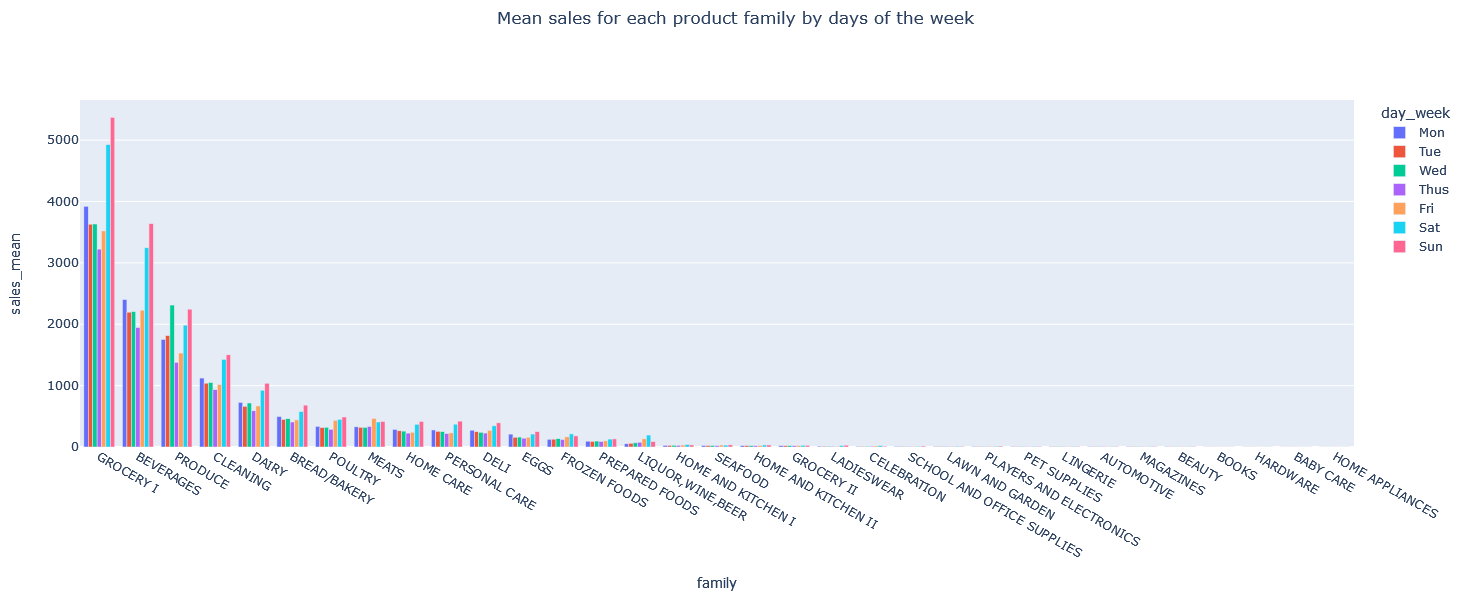

In [39]:
fig = px.bar(dayweek_sales, x = 'family', y = 'sales_mean',title = 'Mean sales for each product family by days of the week', color ='day_week',barmode ='group', height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Nota-se pelo gráfico que para as 6 primeiras famílias do gráfico ocorre maiores médias de vendas durante os finais de semana, sábado e domingo, e mínimas de vendas nas quintas-feiras. 

Dessas famílias, somente 'PRODUCE' apresenta maior média de venda nas quartas-feiras do que aos fins de semana.

Das famílias de 'GROCERY I' à 'EGGS' o maior valor de média de vendas ocorre no domingo

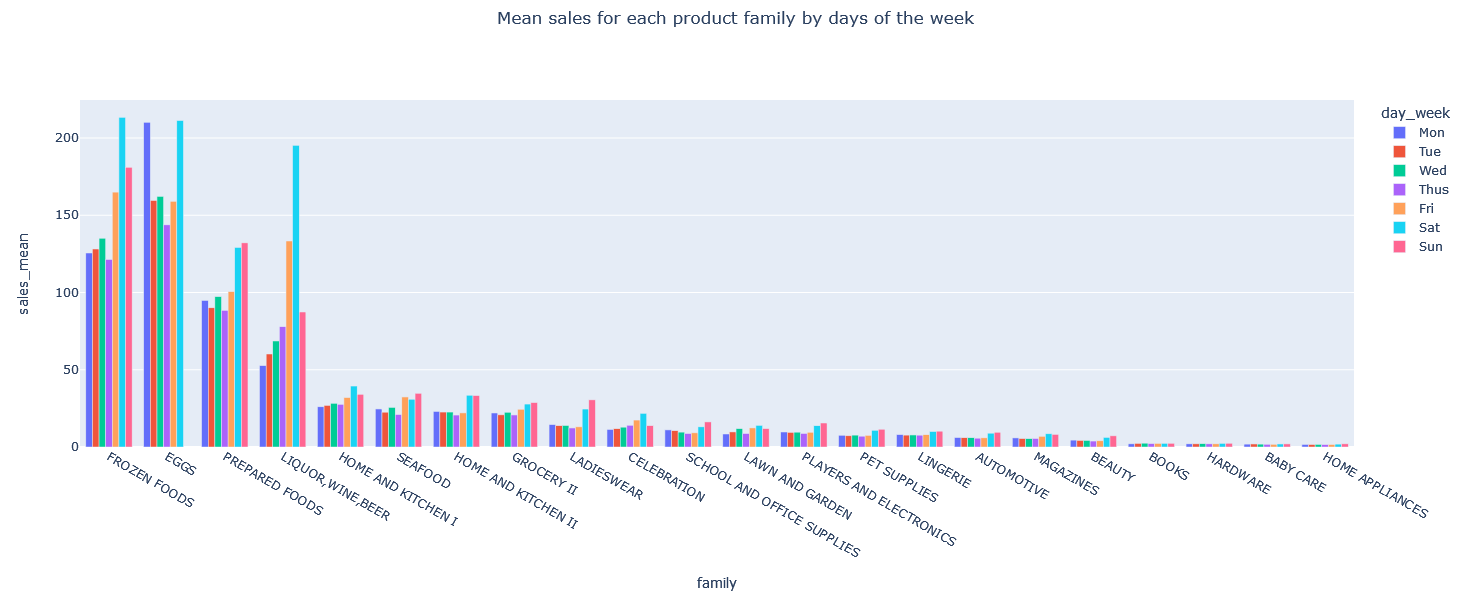

In [40]:
aux = dayweek_sales[dayweek_sales['sales_mean']<215]
fig = px.bar(aux, x = 'family', y = 'sales_mean',title = 'Mean sales for each product family by days of the week', color ='day_week',barmode ='group', height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Para os produtos de baixa demanda, com médias menores que 215, o mesmo efeito tende a acontecer, tendo valores maiores de média de vendas aos sábados e domingos do que nos outros dias da semana, sendo a maior média acontecendo aos domingos. 

As únicas exceções desse efeito, para médias menores, é em 'LIQUOR, WINE, BEER' e 'FROZEN FOODS', onde a menor média de vendas acontece na segunda feira e a máxima acontece aos sabados.

Para validar a afirmação que os finais de semana vendem mais que os dias de semana será feito o mesmo teste de hipótese realizado na questão anterior., utilizando inicialmente o teste de normalidade para depois decidir qual será o teste a ser aplicado. Para isto, os dados serão separados em dois grupos por família, um de segunda-feira à sexta-feira e o outro grupo de sábado e domingo.

In [41]:
aux = train_merged[train_merged['type_holiday'] == 'None']
df_aux = aux[aux['sales']>0]
df1 = df_aux[df_aux['day_week']<5]
df2 = df_aux[df_aux['day_week']>4]

family_list = train_merged['family'].unique()
result_test = pd.DataFrame(np.zeros([len(family_list),2]), columns = ['weekday','Weekend'], index = family_list)

for i in range(0,len(family_list)):
    df_val1 = df1[df1['family'] == family_list[i]]
    df_val2 = df2[df2['family'] == family_list[i]]
    k2, p1 = stats.normaltest(df_val1.sales)
    k2, p2 = stats.normaltest(df_val2.sales)

    if p1<0.05:
        result_test.iloc[i,0] = 'Non-normal dist'
    else:
        result_test.iloc[i,0] = 'Normal dist'
        
    if p2<0.05:
        result_test.iloc[i,1] = 'Non-normal dist'
    else:
        result_test.iloc[i,1] = 'Normal dist'
        
result_test

weekday          Weekend
AUTOMOTIVE                  Non-normal dist  Non-normal dist
BABY CARE                   Non-normal dist  Non-normal dist
BEAUTY                      Non-normal dist  Non-normal dist
BEVERAGES                   Non-normal dist  Non-normal dist
BOOKS                       Non-normal dist  Non-normal dist
BREAD/BAKERY                Non-normal dist  Non-normal dist
CELEBRATION                 Non-normal dist  Non-normal dist
CLEANING                    Non-normal dist  Non-normal dist
DAIRY                       Non-normal dist  Non-normal dist
DELI                        Non-normal dist  Non-normal dist
EGGS                        Non-normal dist  Non-normal dist
FROZEN FOODS                Non-normal dist  Non-normal dist
GROCERY I                   Non-normal dist  Non-normal dist
GROCERY II                  Non-normal dist  Non-normal dist
HARDWARE                    Non-normal dist  Non-normal dist
HOME AND KITCHEN I          Non-normal dist  Non-normal dist
HOME AND KITCHEN II         Non-normal dist  Non-normal dist
HOME APPLIANCES             Non-normal dist  Non-normal dist
HOME CARE                   Non-normal dist  Non-normal dist
LADIESWEAR                  Non-normal dist  Non-normal dist
LAWN AND GARDEN             Non-normal dist  Non-normal dist
LINGERIE                    Non-normal dist  Non-normal dist
LIQUOR,WINE,BEER            Non-normal dist  Non-normal dist
MAGAZINES                   Non-normal dist  Non-normal dist
MEATS                       Non-normal dist  Non-normal dist
PERSONAL CARE               Non-normal dist  Non-normal dist
PET SUPPLIES                Non-normal dist  Non-normal dist
PLAYERS AND ELECTRONICS     Non-normal dist  Non-normal dist
POULTRY                     Non-normal dist  Non-normal dist
PREPARED FOODS              Non-normal dist  Non-normal dist
PRODUCE                     Non-normal dist  Non-normal dist
SCHOOL AND OFFICE SUPPLIES  Non-normal dist  Non-normal dist
SEAFOOD                     Non-normal dist  Non-normal dist

Da mesma forma será aplicado a transformação de box-cox para ferificar se é possível transformar os dados em uma distribuição gaussiana.

In [42]:
result_test = pd.DataFrame(np.zeros([len(family_list),2]), columns = ['weekday','Weekend'], index = family_list)

for i in range(0,len(family_list)):
    df_val1 = df1[df1['family'] == family_list[i]]
    df_val2 = df2[df2['family'] == family_list[i]]
    x1,_ = stats.boxcox(df_val[fillter].sales)
    x2,_ = stats.boxcox(df_val[fillter].sales)
    
    k2, p1 = stats.normaltest(x1)
    k2, p2 = stats.normaltest(x2)

    if p1<0.05:
        result_test.iloc[i,0] = 'Non-normal dist'
    else:
        result_test.iloc[i,0] = 'Normal dist'
        
    if p2<0.05:
        result_test.iloc[i,1] = 'Non-normal dist'
    else:
        result_test.iloc[i,1] = 'Normal dist'
        
result_test

weekday          Weekend
AUTOMOTIVE                  Non-normal dist  Non-normal dist
BABY CARE                   Non-normal dist  Non-normal dist
BEAUTY                      Non-normal dist  Non-normal dist
BEVERAGES                   Non-normal dist  Non-normal dist
BOOKS                       Non-normal dist  Non-normal dist
BREAD/BAKERY                Non-normal dist  Non-normal dist
CELEBRATION                 Non-normal dist  Non-normal dist
CLEANING                    Non-normal dist  Non-normal dist
DAIRY                       Non-normal dist  Non-normal dist
DELI                        Non-normal dist  Non-normal dist
EGGS                        Non-normal dist  Non-normal dist
FROZEN FOODS                Non-normal dist  Non-normal dist
GROCERY I                   Non-normal dist  Non-normal dist
GROCERY II                  Non-normal dist  Non-normal dist
HARDWARE                    Non-normal dist  Non-normal dist
HOME AND KITCHEN I          Non-normal dist  Non-normal dist
HOME AND KITCHEN II         Non-normal dist  Non-normal dist
HOME APPLIANCES             Non-normal dist  Non-normal dist
HOME CARE                   Non-normal dist  Non-normal dist
LADIESWEAR                  Non-normal dist  Non-normal dist
LAWN AND GARDEN             Non-normal dist  Non-normal dist
LINGERIE                    Non-normal dist  Non-normal dist
LIQUOR,WINE,BEER            Non-normal dist  Non-normal dist
MAGAZINES                   Non-normal dist  Non-normal dist
MEATS                       Non-normal dist  Non-normal dist
PERSONAL CARE               Non-normal dist  Non-normal dist
PET SUPPLIES                Non-normal dist  Non-normal dist
PLAYERS AND ELECTRONICS     Non-normal dist  Non-normal dist
POULTRY                     Non-normal dist  Non-normal dist
PREPARED FOODS              Non-normal dist  Non-normal dist
PRODUCE                     Non-normal dist  Non-normal dist
SCHOOL AND OFFICE SUPPLIES  Non-normal dist  Non-normal dist
SEAFOOD                     Non-normal dist  Non-normal dist

Como não foi possível realizar a transformação de nenhuma das variáveis, será utilizado o teste não-paramétrico de 'Mann-Whitney' comparando os dados de dias da semana com os dias dos finais de semana.
Neste caso temos:
- Neste teste de normalidade será atribuido um nível de significãncia de 0.05.
- A hipótese nula é que a média de vendas em dias de semana é maior ou igual a média dos dias de final de semana.
- A hipótese alternativa é que a  média de vendas em dias de semana é menor a média dos dias de final de semana.

Portanto será avaliado se a hipótese nula é aceita ou rejeitada.

In [43]:

MW_result = pd.DataFrame(np.zeros([len(family_list),1]), columns = ['weekday - Weekend'], index = family_list)

for i in range(0,len(family_list)):
    df_val1 = df1[df1['family'] == family_list[i]]
    df_val2 = df2[df2['family'] == family_list[i]]
    st,p = stats.mannwhitneyu(df_val1.sales, df_val2.sales, alternative= 'greater')    
    
    if p<0.05:
        MW_result.iloc[i] = 'Accept' # accept the null hypothesis
    else:
        MW_result.iloc[i] = 'Reject' # reject the null hypothesis
        
MW_result

weekday - Weekend
AUTOMOTIVE                            Reject
BABY CARE                             Reject
BEAUTY                                Reject
BEVERAGES                             Reject
BOOKS                                 Reject
BREAD/BAKERY                          Reject
CELEBRATION                           Reject
CLEANING                              Reject
DAIRY                                 Reject
DELI                                  Reject
EGGS                                  Reject
FROZEN FOODS                          Reject
GROCERY I                             Reject
GROCERY II                            Reject
HARDWARE                              Reject
HOME AND KITCHEN I                    Reject
HOME AND KITCHEN II                   Reject
HOME APPLIANCES                       Reject
HOME CARE                             Reject
LADIESWEAR                            Reject
LAWN AND GARDEN                       Reject
LINGERIE                              Reject
LIQUOR,WINE,BEER                      Reject
MAGAZINES                             Reject
MEATS                                 Reject
PERSONAL CARE                         Reject
PET SUPPLIES                          Reject
PLAYERS AND ELECTRONICS               Reject
POULTRY                               Reject
PREPARED FOODS                        Reject
PRODUCE                               Reject
SCHOOL AND OFFICE SUPPLIES            Reject
SEAFOOD                               Reject

Analisando a tabela vemos que em todos os casos a hipótese nula foi rejeitada,  ou seja, em todas das famílias o final de semana em um dia 'comum' aumenta a quantidade de vendas.

Portanto, temos as seguintes conclusões:
- Pelo gráfico vemos que, em grande parte das famílias, a demanda de produtos é menor na quarta-feira.
- A maior média de compras para a maioria das famílias acontece ao domingo.
- A hipótese de que em fins de semana a média de vendas é maior do que os dias de semana é estatisticamente significante.
- A feature 'day_week' pode ter um impacto positivo no modelo.

## Question 4

In [44]:
aux = train_merged[train_merged['sales']>0].sales.count()
store_sales = train_merged.groupby(['store_nbr','year']).agg(perc_occ = ('sales',lambda x: np.round(100*np.sum(x>0)/aux,2)),
                                                               sales_sum = ('sales','sum')) 
store_sales.reset_index(inplace = True)
store_sales['year'] = store_sales['year'].replace([2013,2014,2015,2016,2017],['2013','2014','2015','2016','2017'])

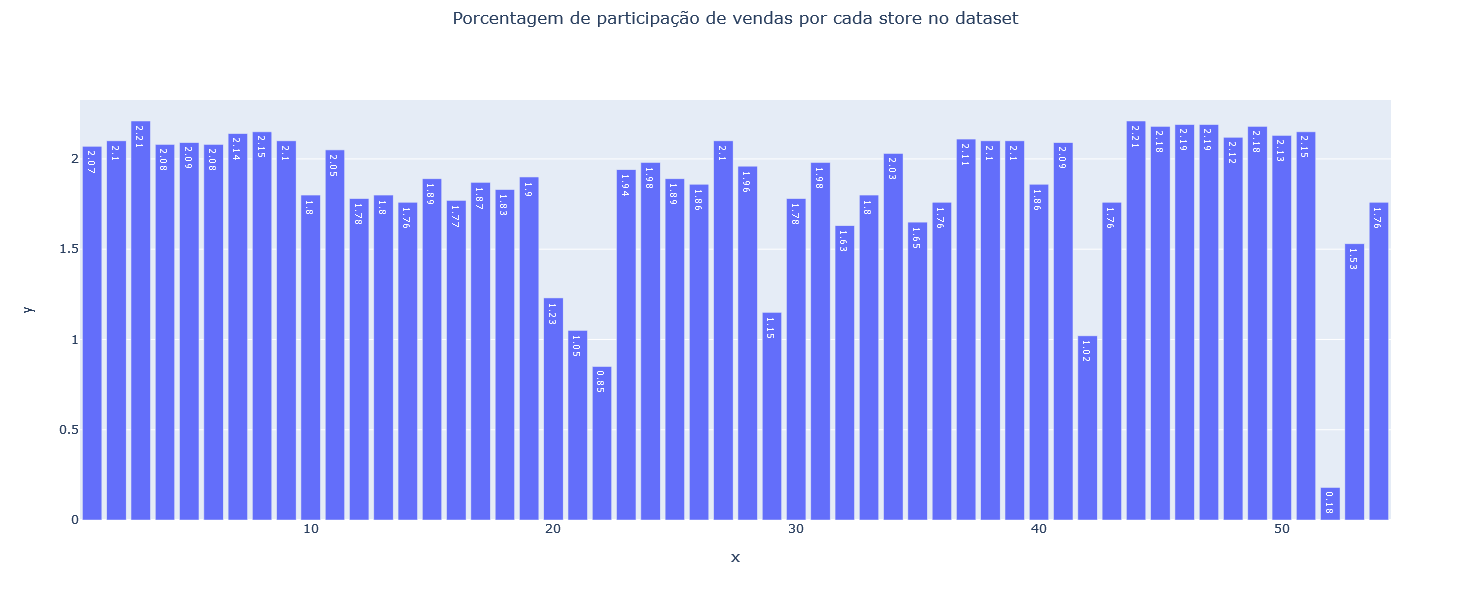

In [45]:
fig = px.bar(x = store_sales['store_nbr'].unique(), y = store_sales.groupby('store_nbr')['perc_occ'].sum(),text_auto=True, 
             title = 'Porcentagem de participação de vendas por cada store no dataset',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Pelo gráfico vemos que o máximo de participação de vendas por cada store é de 2.21%, alcançado pelos stores 3 e 44, e que a maioria dos stores possui participação acima de 1.5%.

Nota-se que a presença de vendas para o store 52 é baixíssima, próxima à 0.2%, e que os stores 20, 21, 22, 29 e 42 possuem participação a baixo de 1,5% nas vendas. 

Para uma melhor compreensão também será analisado a participação de vendas de cada store em cada ano.

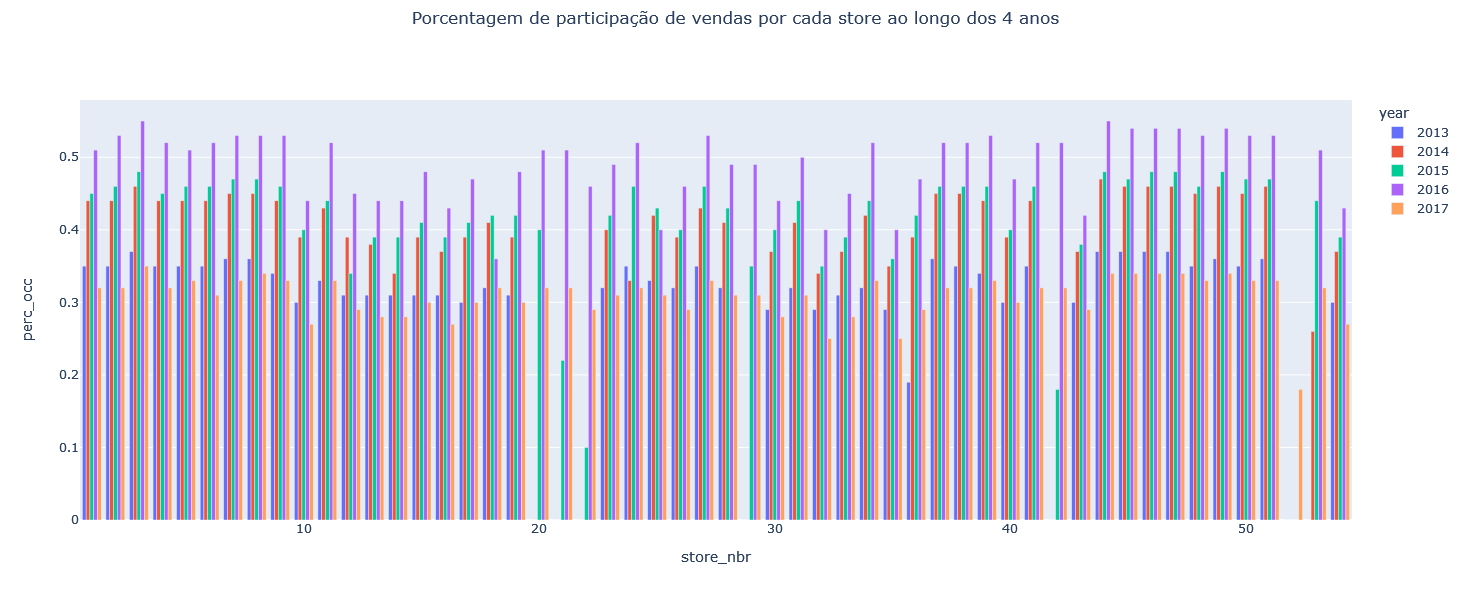

In [46]:
fig = px.bar(store_sales, x = 'store_nbr', y = 'perc_occ',color = 'year', barmode = 'group',
             title = 'Porcentagem de participação de vendas por cada store ao longo dos 4 anos',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Nota-se neste gráfico que, o store 52 possui uma baixa participação de vendas devido a sua construção ou a aquisição de dados ter ocorrido apartir de 2017. Porém, se for analisado somente o ano de 2017, ele ainda continua sendo o store com menor participação de vendas, sendo o unico com menos de 0.2% de participação.

Os stores  20, 21, 22, 29 e 42 apresentam uma participação menor que os demais deviso a sua contrução ou a aquisição de dados ter começado no ano de 2015. E analisando o ano de 2015, os stores 22, 42 e 21 foram os que tiveram pior desempenho em vendas.

Analisando todos os anos juntos, nota-se o mesmo aumento de participação de vendas em todos os stores ao longo dos anos, com excessão do ano de 2017 pois o mesmo não é um ano completo de dados.

Somente o store 24 apresentou uma queda de participação de vendas de 2013 para 2014. 

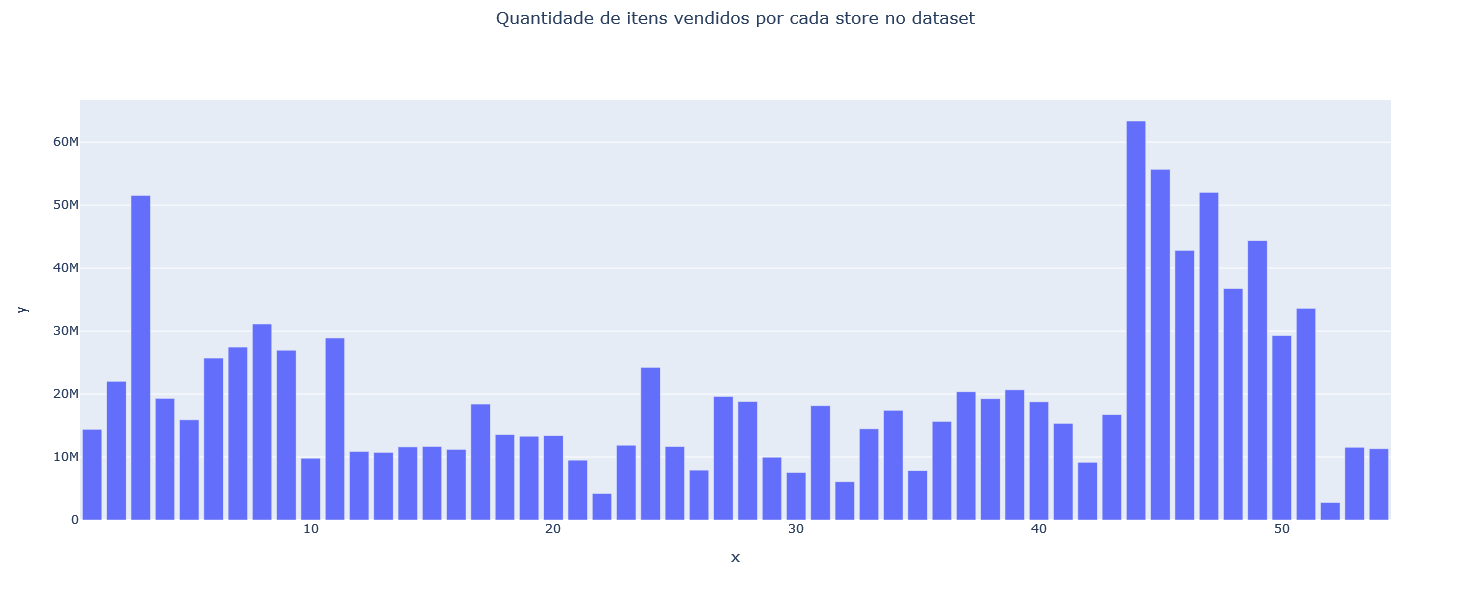

In [47]:
fig = px.bar(x = store_sales['store_nbr'].unique(), y = store_sales.groupby('store_nbr')['sales_sum'].sum(), 
             title = 'Quantidade de itens vendidos por cada store no dataset',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Nota-se pelo gráfico que apesar da maioria dos stores ter uma porcentagem de participação de vendas parecidos a quantidade de itens vendidos difere muito entre eles. Os que apresentam maior quantidade de itens vendidos são os stores 3, 44, 45 e 47, apresentando apresentando mais de 50 milhões de itens vendidos ao longo dos 4 anos.

A maioria dos stores apresenta quantidade próximas ou menores que 10 milhões de itens vendidos ao longo dos 4 anos.

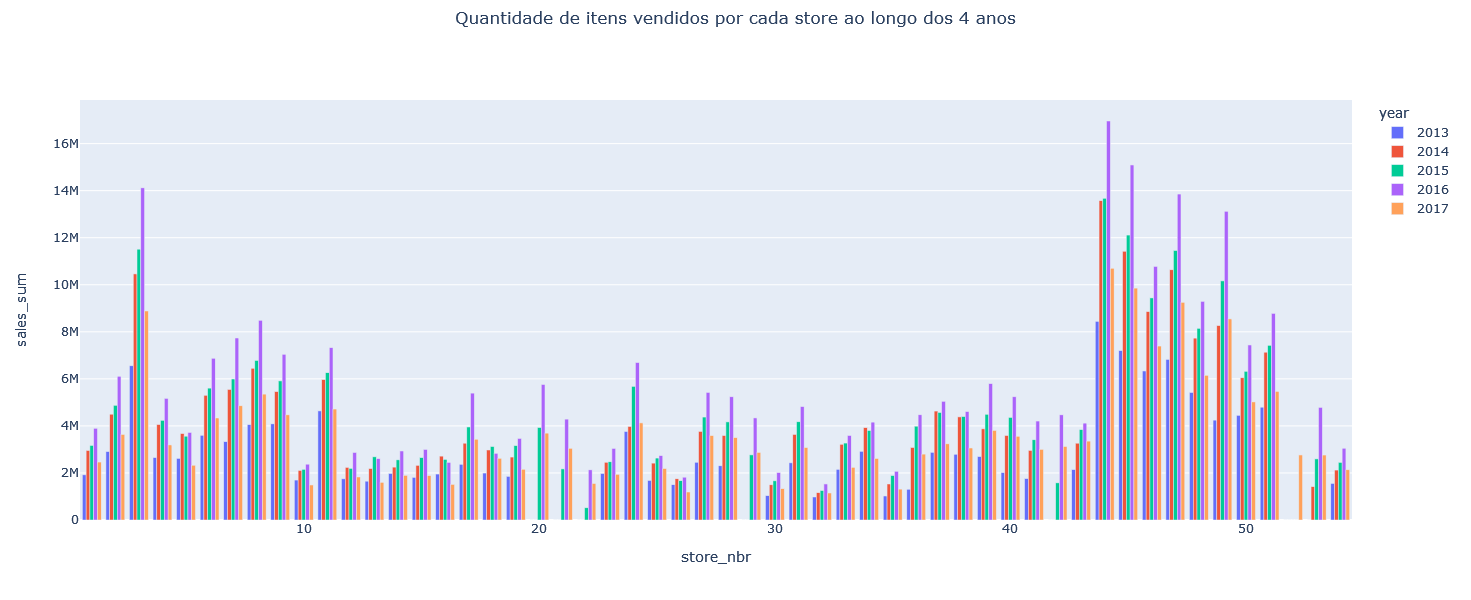

In [48]:
fig = px.bar(store_sales, x = 'store_nbr', y = 'sales_sum',color = 'year', barmode = 'group',
             title = 'Quantidade de itens vendidos por cada store ao longo dos 4 anos',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Pelo gráfico observa-se que os stores 3, 44, 45 e 47 apresentam uma consistência de serem os stores com maior quantidade de vendas em todos os anos.

Novamente é possível observar uma crescente de vendas ao longo dos anos em todos os stores.

Com essas análises é possível retirar as seguintes conclusões:
- Os stores possuem participação no dataset de maneira equivalente.
- A feature 'store_nbr' pode ter um impacto positivo no desenvolvimento do modelo.
- O store 52 pode apresentar problemas de previsão, devido a sua baixa ocorrência no dataset.
- Os stores 3, 44, 45 e 47 podem apresentar melhor desempenho nas previsões, devido a sua grande participação nas vendas.


## Question 5

In [49]:
#- Como é a distribuição de promoções para cada família de produto?
train_merged.shape

(3054348, 23)

In [50]:
onpromotion_sales = train_merged.groupby(['family','year']).agg(occ = ('onpromotion',lambda x: np.sum(x>0))) 
onpromotion_sales.reset_index(inplace = True)
onpromotion_sales['year'] = onpromotion_sales['year'].replace([2013,2014,2015,2016,2017],['2013','2014','2015','2016','2017'])

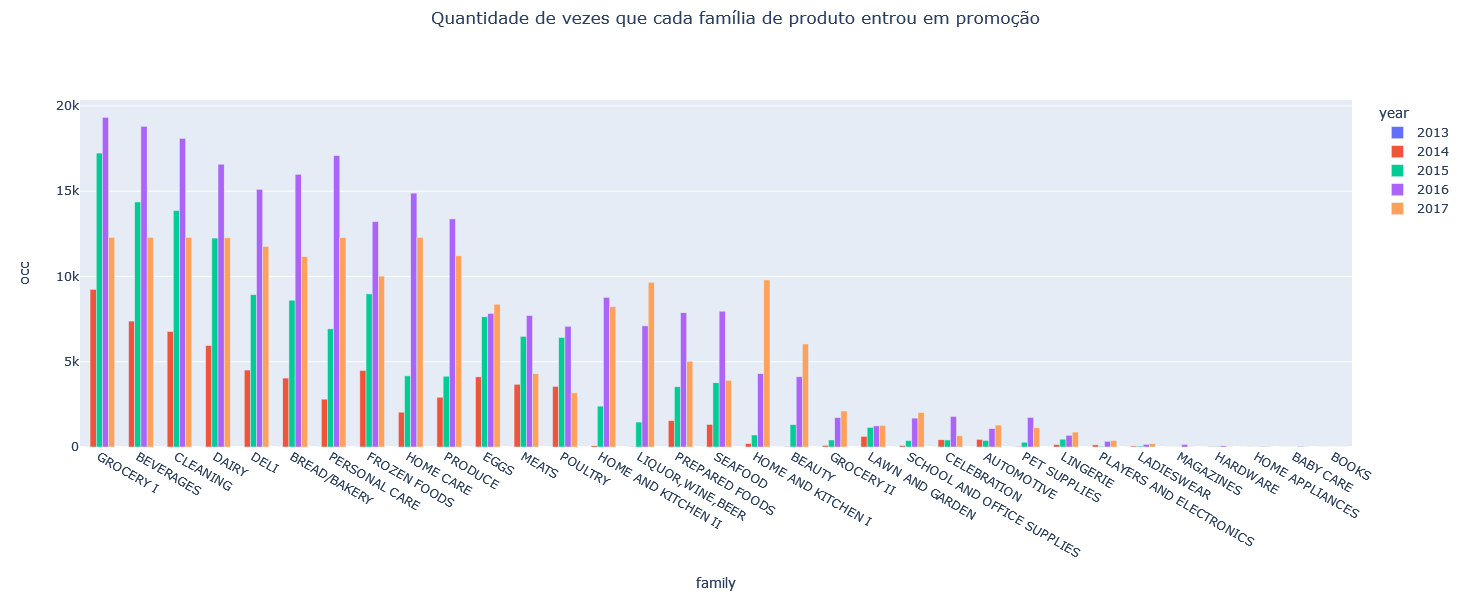

In [51]:
fig = px.bar(onpromotion_sales, x = 'family', y = 'occ', barmode ='group',color = 'year',
             title = 'Quantidade de vezes que cada família de produto entrou em promoção',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Nota-se pelo gráfico que a quantidade de vezes que algum produto entra em promoção vem aumentando a cada ano, principalmente para as famílias de produtos alimentícios e de consumo diário. 

Observa-se também um aumento de promoção expressivo a partir de 2015 nos itens de: 'GROCERY II', 'SCHOOL AND OFFICE SUPPLIES', 'CELEBRATION', 'AUTOMATIVE' E 'PET SUPPLIES' que são itens de baixa demanda, e em itens como: 'HOME CARE', 'PRODUCE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II'  e 'LIQUOR,WINE,BEER', que são itens de média demanda. 

É possível inferir também que produtos das famílias: 'GROCERY I', 'BEVERAGES', 'CLEANING', 'DAIRY' e 'PERSONAL CARE' tiveram pelo menos 1 produto em promoção em praticamente todos os stores quase o ano de 2016 inteiro.

In [52]:
train_merged['promotion'] = train_merged['onpromotion'].agg(lambda x: True if x>0 else False)

promotion_sales = train_merged[train_merged['sales']>0].groupby(['family','promotion']).agg(promo_sum = ('sales','sum'), promo_mean = ('sales','mean'),
                                                                                            promo_max = ('sales','max'), promo_min = ('sales','min'))
promotion_sales.reset_index(inplace = True)

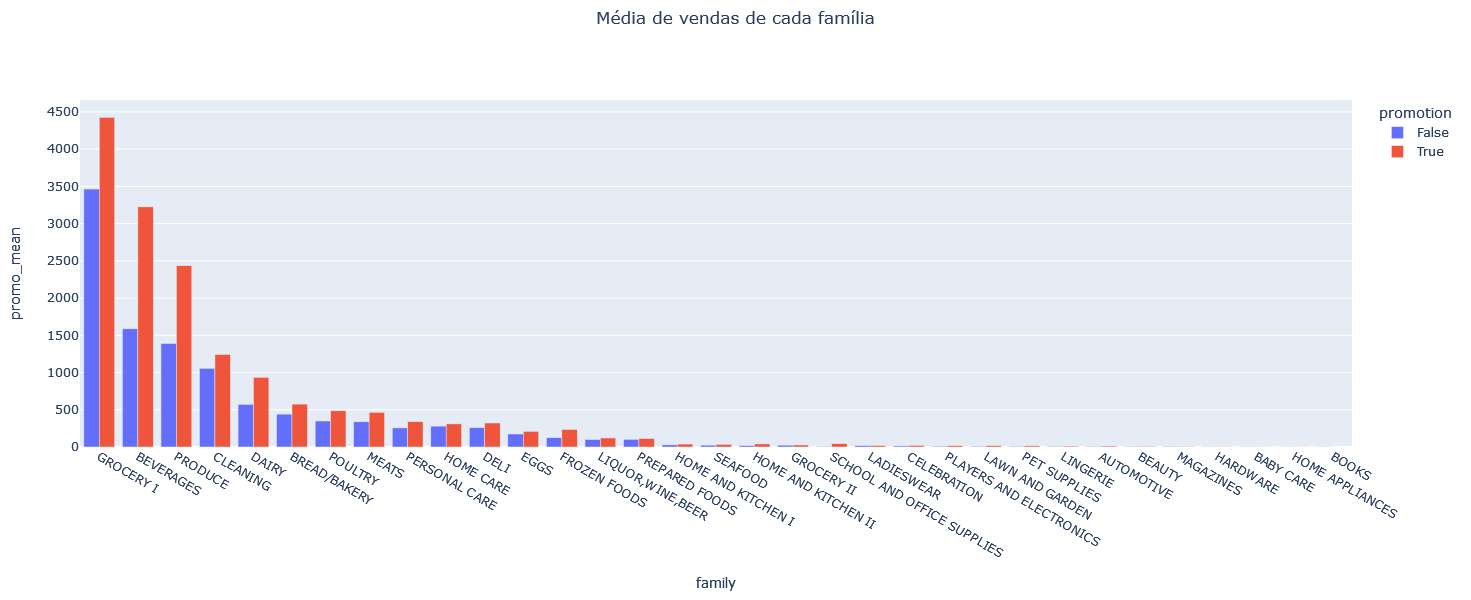

In [53]:
fig = px.bar(promotion_sales, x = 'family', y = 'promo_mean', barmode ='group',color = 'promotion',
             title = 'Média de vendas de cada família',height=600)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Nota-se pelo gráfico que a média de vendas para todas as famílias é maior quando o produto está em promoção. Em alguns casos ocorre aumento de quase 100% da média, como em 'BEVERAGES' e 'PRODUCE'.

In [ ]:
#fig = px.scatter(train_merged[train_merged['sales']>0], x = 'sales', y = 'onpromotion',color = 'family', title = 'Quantidade de itens vendidos por quantidade de itens em promoção',height=600)
#fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
#fig.show()
# Gráfico pesado

Analisando o gráfico selecionando somente uma família é possível identificar um padrão em produtos de alta/média demanda, como 'GROCERY I', 'PRODUCE', 'BREAD/BAKERY','DAIRY', etc... Onde existe duas regiões, uma com valores baixos de promoção onde ocorre uma relação linear negativa (quando ocorre menos promoções o produto é mais vendido) e uma outra região com valores médio/alto de itens em promoção que possui uma relação linear positiva (quanto maior o número de itens em promoção maior é a quantidade de vendas). 

Porém em todos os casos a região de relação linear positiva sempre possui um número de vendas menor que a outra região, contrariando o que foi visualizado no gráfico anterior, onde a média de vendas em promoção era maior do que sem promoção. Isto pode ter sido gerado pois o dataset consta mais dados de venda com itens em promoção do que de vendas sem promoção, mas não necessariamente a 'promoção' que resultou naquela quantidade de itens vendidos.

Para uma melhor interpretação dos dados de venda seria separar as informações de venda de produtos sem promoção dos produtos com promoção, para realmente identificar se a promoção tem ou não um impacto positivo nas vendas.

Com essas análises é possível retirar as seguintes conclusões:
- Existe uma tendência de aumentar o número de itens em promoção com o passar dos anos.
- Não é possível identificar se a feature 'onpromotion' terá um desempenho positivo ou negativo na elaboração do modelo.

# Question 6

Será feito o teste de estacionariedade (ADFuller) para verificar se todas as séries temporais trabalhadas (cada família para cada store) são séries estacionárias, permitindo que sejam realizadas certas manipulações para criar novas features. 

O teste de ADfuller é um teste do tipo Hipótese de Raiz Unitária no qual ele tenta determinar o quão forte a série temporal é definida por uma tendência. Se o resultado do ADF for menor do que o valor critico para um determinado percentual (5% no nosso caso) e o p-value for significante (menor que 0.05), a série é considerada estacionária, do contrário a série é não estacionária.

In [55]:
family_list = train_merged['family'].unique()
store_list = train_merged['store_nbr'].sort_values().unique()
test_ADF = pd.DataFrame(np.zeros([ len(family_list), len(store_list)]), columns = store_list, index = family_list)
train_merged['test_ADF'] = 1
for i in range(0,len(family_list)):
    df_aux1 = train_merged[train_merged['family'] == family_list[i]]
    for j in range(0,len(store_list)):
        df_aux2 = df_aux1[df_aux1['store_nbr'] == store_list[j]]
        
        if df_aux2.sales.sum() == 0:
            test_ADF.iloc[i,j] = 1
        else:
            p = adfuller(df_aux2.sales)
            test_ADF.iloc[i,j] = p[1]
            
        idx = df_aux2.index
        train_merged.loc[idx,'test_ADF'] = test_ADF.iloc[i,j]
        

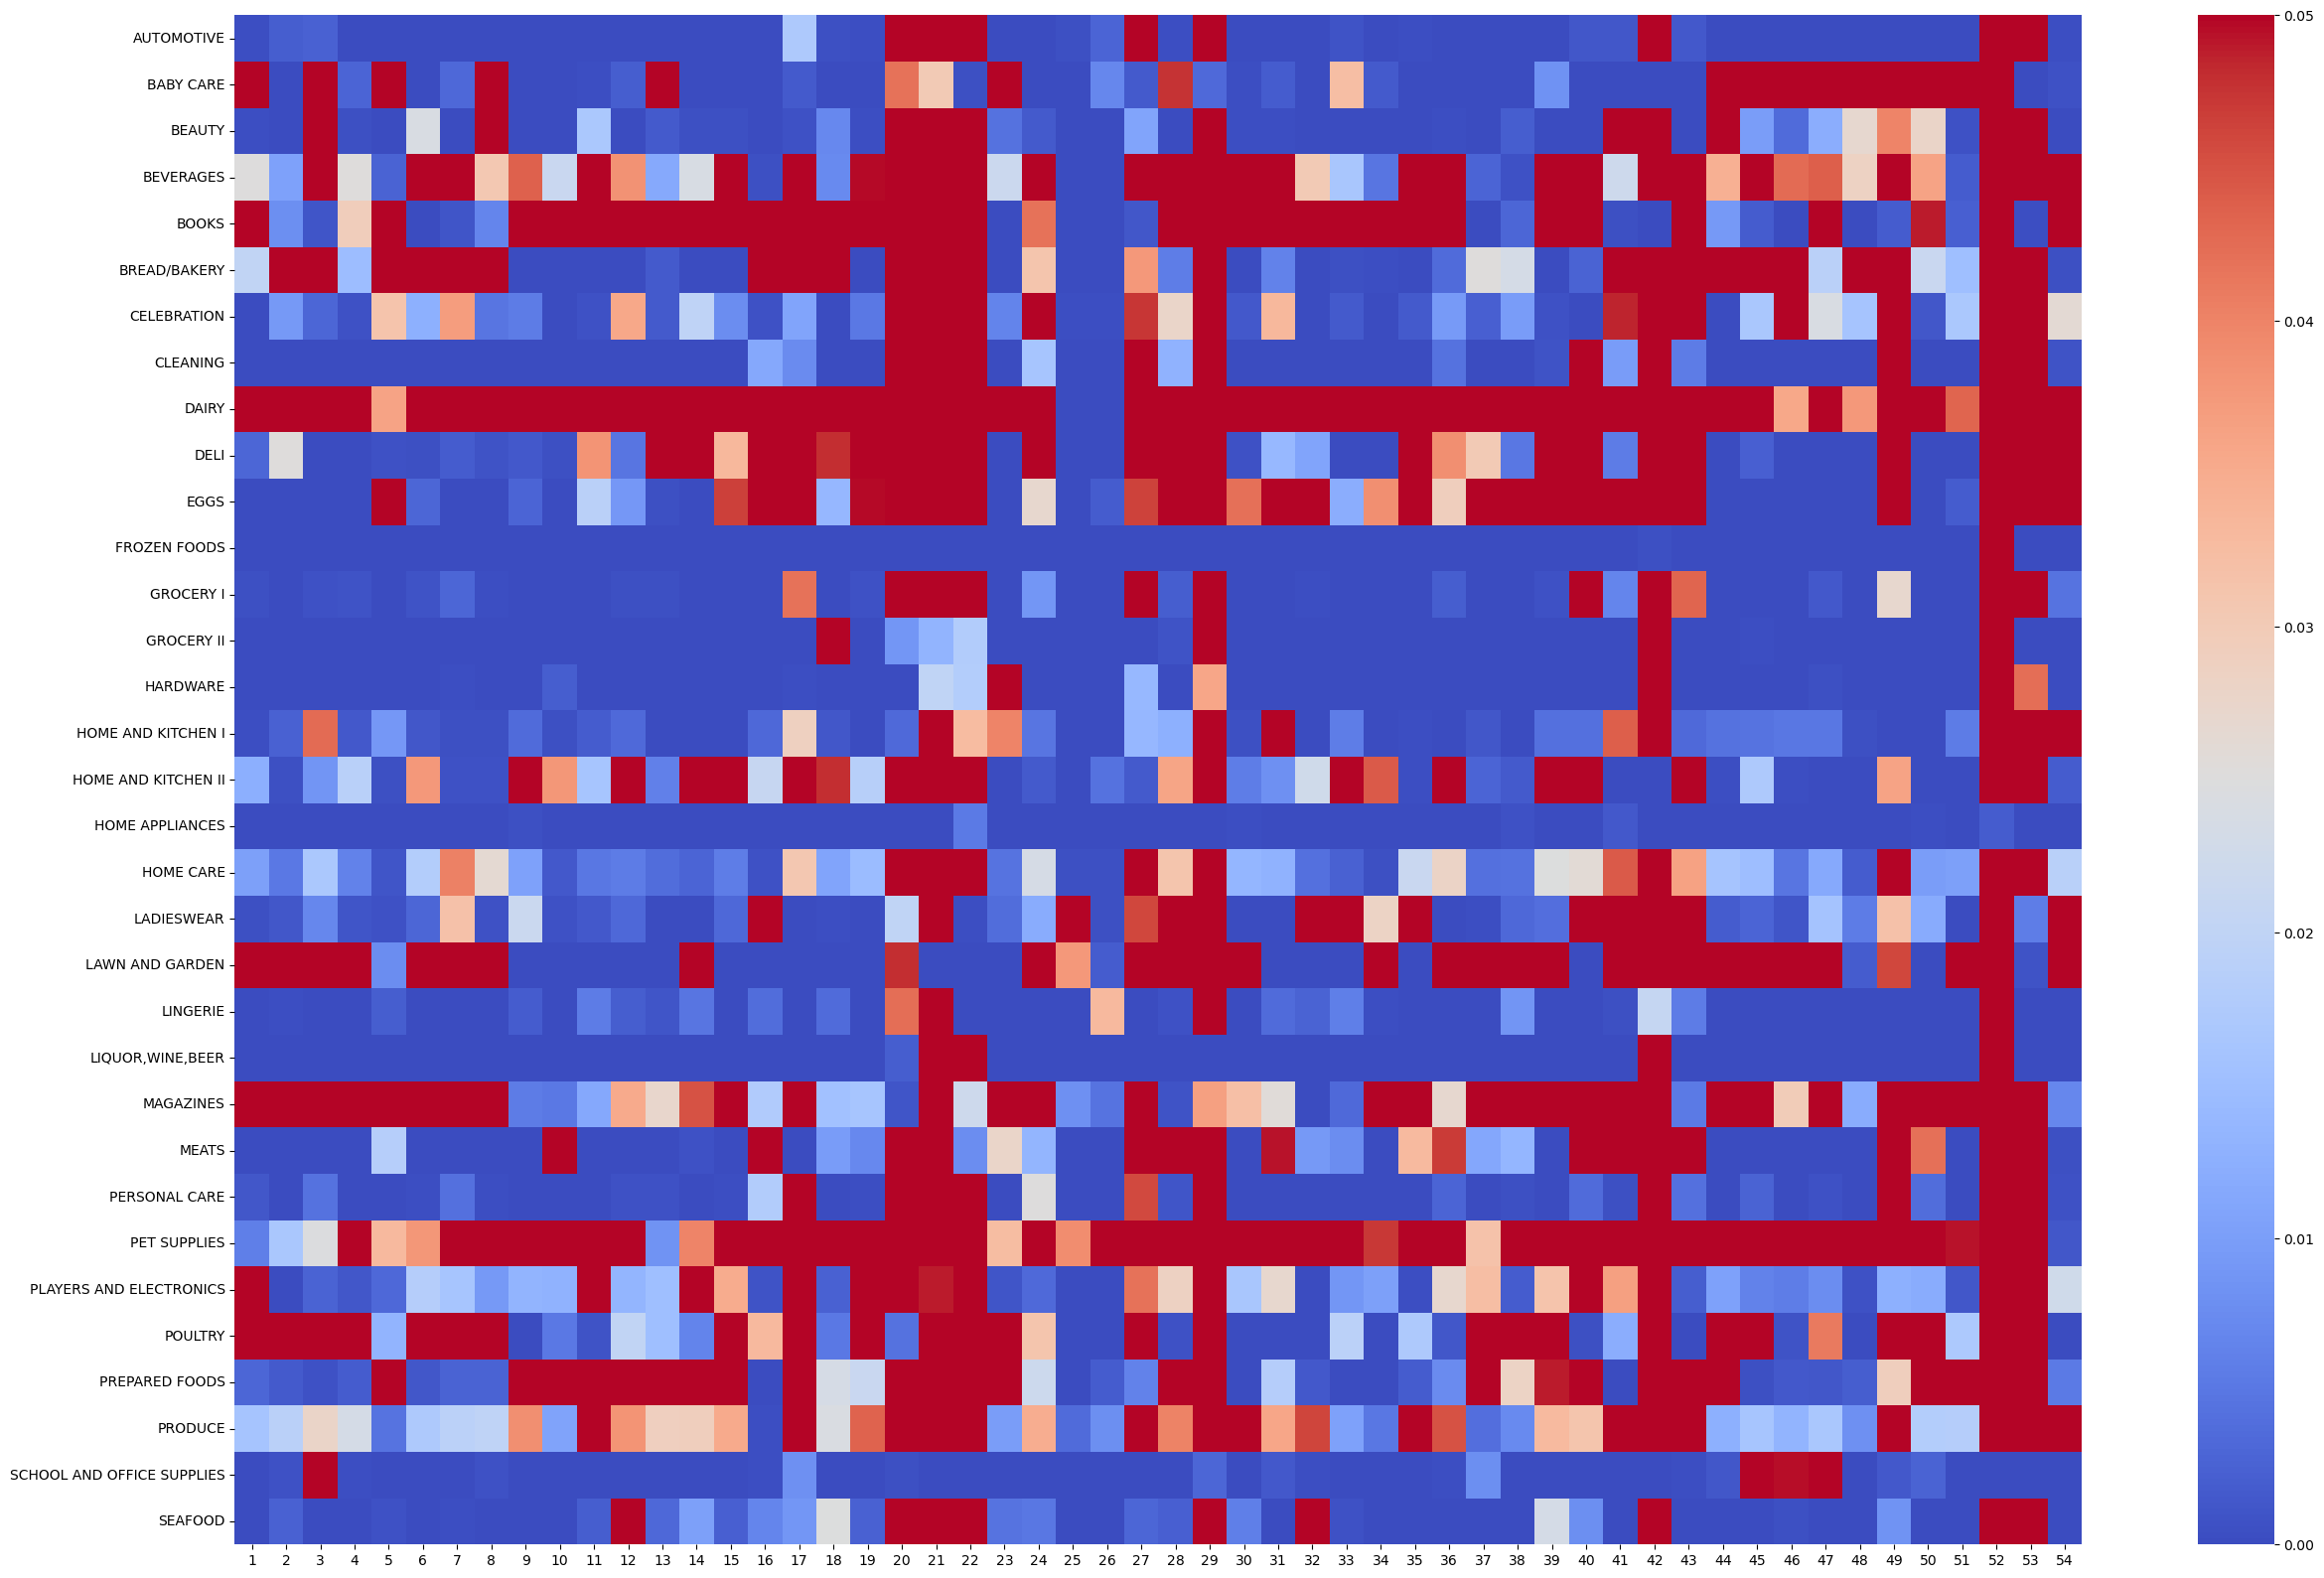

In [ ]:
plt.subplots(1, figsize=(30,20))
sns.heatmap(test_ADF, vmin=0, vmax=0.05,cmap="coolwarm")
plt.show()

Pelo teste aplicado temos que todos os valores acima de 0.05 (5% de significância) são considerados como séries não estacionárias. 

Neste caso deverá ser aplicado dois modelos de machine learning diferentes, um para os dados estacionários e outro para os dados não-estacionários.

Para o caso das séries estacionárias será feito a decomposição da série temporal considerando o lagging de 16 dias e a criação de uma variável relacionando a venda do ano anterior naquele respectivo dia.
Para o caso das séries não estacionárias será feito a criação de uma variável relacionando a venda do ano anterior naquele respectivo dia e uma variável lagging de 'sales' de 16 dias.

Para melhorar o processamento será feito a remoção dos dados anteriores a data de 2015.

In [57]:
train_merged = train_merged[train_merged['date'] >'2015-01-01']
train_NST = train_merged[train_merged['test_ADF'] >=0.05].copy()
train_ST = train_merged[train_merged['test_ADF'] <0.05].copy()

# **New Features - Stationary Time Series**

Para aumentar a capacidade do poder preditivo será criado uma feature com base nos 'sales', onde será utilizado os dados de venda de um dia anterior para prever as vendas do dia atual. Como neste projeto está sendo requerido a previsão de vendas do dia 15 ao dia 31  de vendas de um determinado mês, será utilizado os dados de vendas de 16 dias atrás para prever o dia atual.

Neste caso não está sendo considerado o atraso da logística envolvendo o processo de compra e transporte da mercadoria para o dimensionamento de produtos a serem comprados, visto que neste modelo desenvolvido é 'necessário' saber as vendas de um determinado dia para prever as vendas em um dia posterior. Como não temos base para estimar esse tempo ele não será considerado, mas caso tivessemos esse valor de dias relacionado a esta logística ele deveria ser adicionado como delay no modelo de previsão, para que assim a janela de quantidade de produtos a serem comprados esteja correto.

Não é possivel utilizar os valores da previsão do modelo pois isto acarretaria em acumulação de erro com o passar do tempo. Isto implica que o modelo também tem que ser treinado novamente com o passar destes X dias utilizados como delay, para garantir uma maior precisão. Portanto o modelo a ser desenvolvido também tem que ser um modelo rápido para realizar o treinamento e a otimização.


In [58]:
train_ST[train_ST['date'] == '2017-06-01'].nunique()

id               1276
date                1
store_nbr          54
family             33
sales             550
onpromotion        34
city_store         22
state_store        16
type_store          5
cluster_store      17
type_day            1
type_holiday        1
locale_name         1
description         1
transferred         1
oil_price           1
transactions       53
day                 1
day_week            1
weekmonth           1
month               1
year                1
payment             1
promotion           2
test_ADF         1253
dtype: int64

Analisando a quantidade de dados que temos para somente 1 dia, vemos que é a quantidade de id únicos é 1276, representando a quantidade de dados existentes em um dia. Portanto, neste caso, 16 dias é equivalente á 20.416 linhas que devem ser deslocadas.

Como esse modelo utiliza 16 dias anteriores para realizar a previsão, os 16 primeiros dias do dataset não possuirão esta informação, necessitando serem removidos. Os ultimos 16 dias com os valores de venda serão armazenados em uma feature externa que será implementada para os dados de teste e submissão dos dados.

Além disto será criado as features de tendência e de sazonalidade desta nova variável sales. 

In [59]:
c_ST = train_ST[train_ST['date'] == '2017-06-01']['id'].nunique()*16
c_ST

20416

In [60]:
df_ST = train_ST.dropna().copy()
df_ST.reset_index(inplace = True, drop = True)
store_list = df_ST['store_nbr'].unique()

for i in store_list:
    filt1 =df_ST[df_ST['store_nbr'] == i]
    #print(i)
    family_list = filt1['family'].unique()
    for j in family_list:
        filt2 =filt1[filt1['family'] == j]
        #print(j)
        idx = filt2.index
        result = seasonal_decompose(filt2['sales'],period=16,two_sided = False)
        
        df_ST.loc[idx,'trend'] = result.trend
        df_ST.loc[idx,'seasonality'] = result.seasonal
        df_ST.loc[idx,'resid'] = result.resid
        
df_ST['trend_lagging'] = df_ST['trend'].shift(+c_ST)
df_ST['seasonality_lagging'] = df_ST['seasonality'].shift(+c_ST)
df_ST['resid_lagging'] = df_ST['resid'].shift(+c_ST)
df_ST['transactions_lagging'] = df_ST['transactions'].shift(+c_ST)

ST_lagging = df_ST[['trend','seasonality','resid','transactions']].iloc[-c_ST:].reset_index(drop = True)        
df_ST.drop(['trend','seasonality','resid','transactions'],axis = 1, inplace = True)


df_ST.dropna(inplace = True)

# **Correlation**

In [61]:
df_ST.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'city_store', 'state_store', 'type_store', 'cluster_store', 'type_day',
       'type_holiday', 'locale_name', 'description', 'transferred',
       'oil_price', 'day', 'day_week', 'weekmonth', 'month', 'year', 'payment',
       'promotion', 'test_ADF', 'trend_lagging', 'seasonality_lagging',
       'resid_lagging', 'transactions_lagging'],
      dtype='object')

Para esta análise será utilizado a correlação de 'Kendall's Tau', visando identificar uma correlação entre as variáveis, seja ela de forma linear ou não linear. Caso a correlação seja maior que 0.8 ou menor que -0.8 será removida uma das variáveis para evitar problemas de multicolinearidade.

Para esta aplicação será feito os seguintes tratamentos no dataset:
- Remoção das variáveis 'id' e 'date'.
- Codificação das seguintes variáveis categóricas: 'family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description' e 'transferred'. 

In [62]:
df_ST.drop(labels=['id','date'],axis = 1, inplace = True)
df_ST['transferred'] = df_ST['transferred'].map({True:'true',False:'false','None':'None'})

In [63]:
df_ST[['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred','payment','promotion']].nunique()

store_nbr       54
family          33
city_store      22
state_store     16
type_store       5
type_day         7
type_holiday     4
locale_name     25
description     86
transferred      3
payment          2
promotion        2
dtype: int64

Observando a quantidade de dados únicos para cada variável nota-se uma alta cardinalidade para as seguintes variáveis:'family', 'city_store', 'state_store', 'locale_name' e 'description'.

Para as variáveis de baixa cardinalidade será feito a aplicação do One Hot Enconding, que é uma transformação da variável categórica em um vetor, onde é feito o mapeamento cada categoria em uma entrada desse vetor, onde cada categoria terá sua própria entrada assinalada com um valor de 1 e o restante com 0.

Para as variáveis de alta cardinalidade será feito a aplicação do método 'James-Stein Econding', onde este método busca uma representação da variável categórica pela média da variável de cada categoria com a target, considerando a média global da target e a média local, que seria a média para cada categoria.
Como este método de codificação leva em consideração a 'distribuição' dos dados de cada categoria com a variável, durante a validação e treino do algoritmo este mesmo processo será aplicado nas amostras de 'treino' e seus valores serão repetidos para as amostras de validação e de teste.

In [64]:
def encoder_features(df,Y, feat, drop_list, OHE, JSE, low_card, high_card, df_verify):
    data = df.copy()
    target = Y.copy()
    data.reset_index(inplace = True, drop = True)
    target.reset_index(inplace = True, drop = True)
    # Apply onehot Encoder
    if df_verify == 1: #traning data, apply fit_transform
        coding_hot = OHE.fit_transform(data[low_card].to_numpy())
        aux = pd.DataFrame(coding_hot, columns=OHE.get_feature_names_out(low_card))
        data_cod = pd.concat([data, aux], axis=1).drop(low_card, axis=1)
        
        data_cod[high_card] = JSE.fit_transform(data[high_card], target)
        data_cod.drop(drop_list, axis = 1, inplace = True)
    else: #test or validation data, apply transform
        coding_hot = OHE.transform(data[low_card].to_numpy())
        aux = pd.DataFrame(coding_hot, columns=OHE.get_feature_names_out(low_card))
        data_cod = pd.concat([data, aux], axis=1).drop(low_card, axis=1)

        data_cod[high_card] = JSE.transform(data[high_card])
        data_cod.drop(drop_list, axis = 1, inplace = True) 
        
    return data_cod

In [65]:
feat = ['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred']
drop_list = []
# Verify cardinality
cardinality = df_ST[feat].nunique()
low_card = cardinality[(cardinality<=5) == True].index.tolist()
high_card = cardinality[(cardinality>5) == True].index.tolist()

# Create encoder and apply encoder
onehot = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
JSE_encoder = JamesSteinEncoder()
df_STC = encoder_features(df_ST.drop(['sales'],axis = 1), df_ST['sales'], feat, drop_list, onehot, JSE_encoder, low_card, high_card, 1)

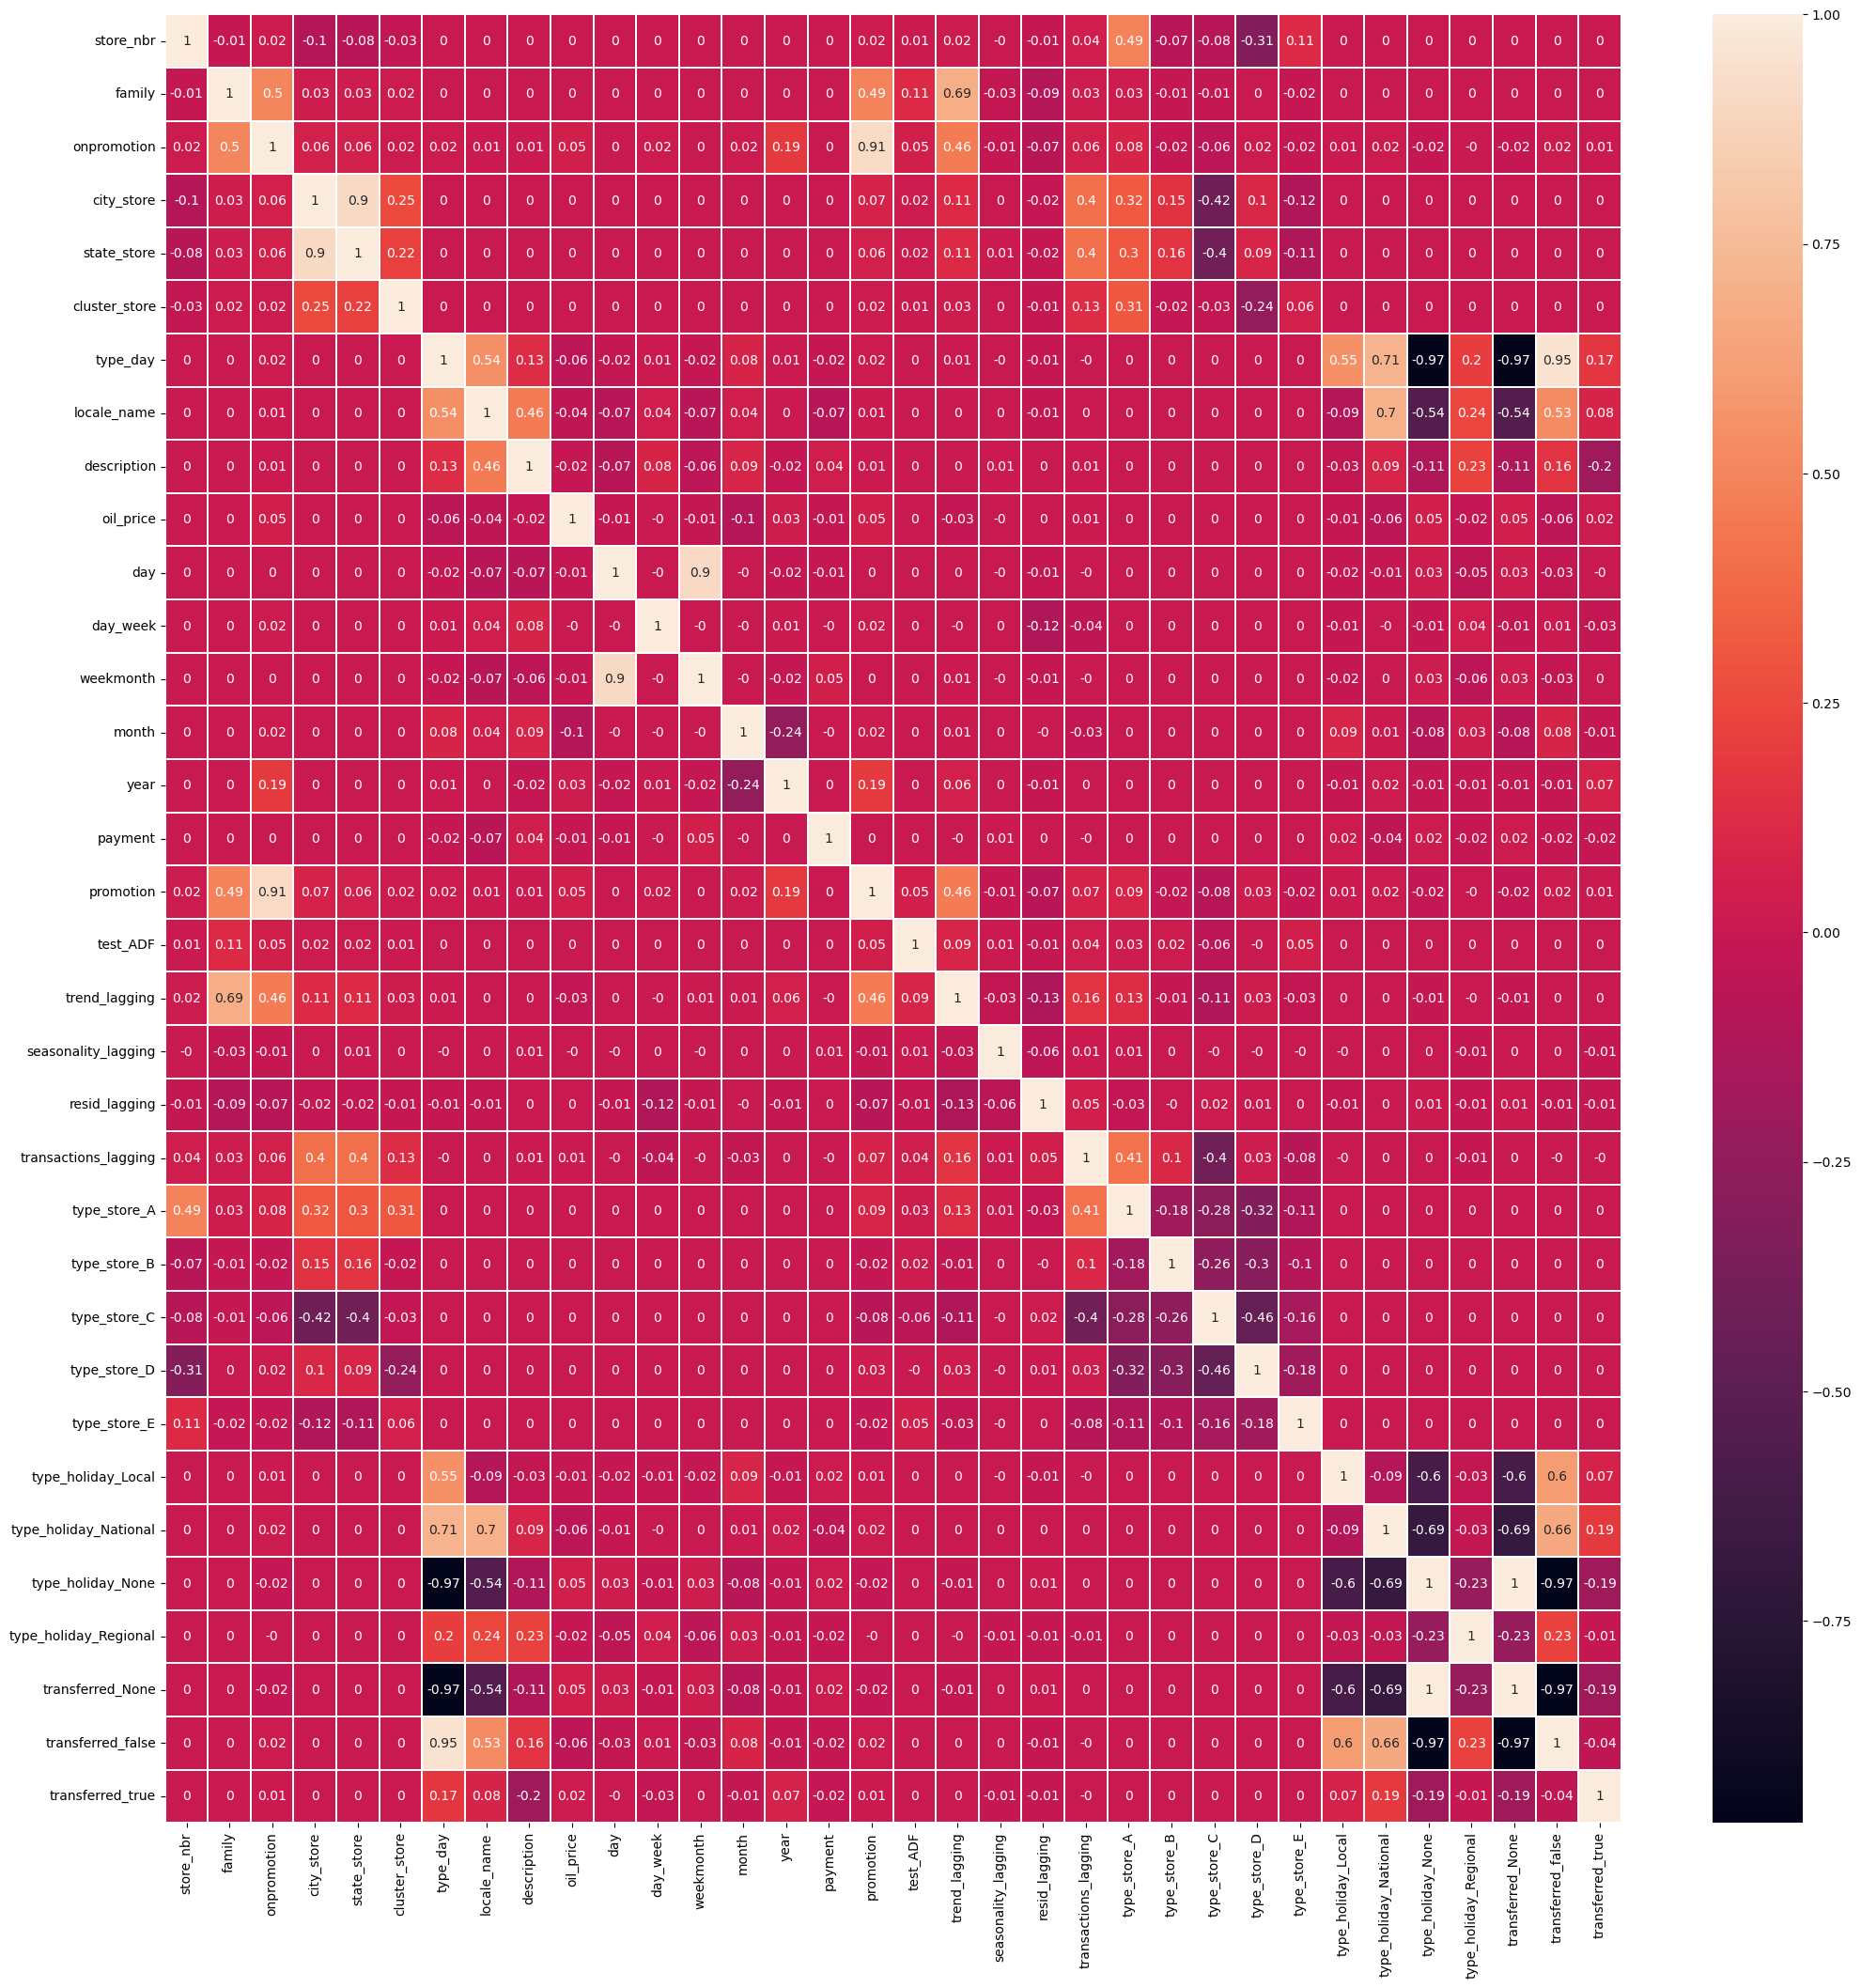

In [ ]:
fig, axes = plt.subplots(1, figsize=(25,25))
kendall_matrix = np.round(df_STC.corr(method='kendall'),2)
fig = sns.heatmap(kendall_matrix, annot=True,linewidths=.1)

Analisando o gráfico de correlação nota-se algumas variáveis com valor de correlação acima de 0.8. 

Portanto as seguintes variáveis serão removidas durante a aplicação do modelo:'state_store', 'weekmonth', 'type_holiday_National', 'type_holiday_None', 'transferred_None', 'transferred_false', 'onpromotion'.

# **Non Stationary Time Series**

Para os dados não estacionários só será realizado a análise de correlação e remoção de variáveis com valor de correlação acima de 0.8. Também será aplicado o lagging de 16 dias para a variável target.

In [67]:
c_NST = train_NST[train_NST['date'] == '2017-01-01']['id'].nunique()*16
c_NST

8096

In [68]:
df_NST = train_NST.dropna().copy()
df_NST['sales_lagging'] = df_NST['sales'].shift(+c_NST)
df_NST['transactions_lagging'] = df_NST['transactions'].shift(+c_NST)
NST_lagging = df_NST[['sales','transactions']].iloc[-c_NST:].reset_index(drop = True)  
df_NST.drop(['transactions'],axis = 1, inplace = True)
df_NST.dropna(inplace = True)

In [69]:
df_NST.drop(labels=['id','date'],axis = 1, inplace = True)
df_NST['transferred'] = df_NST['transferred'].map({True:'true',False:'false','None':'None'})

In [70]:
feat = ['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred']
drop_list = []
# Verify cardinality
cardinality = df_ST[feat].nunique()
low_card = cardinality[(cardinality<=5) == True].index.tolist()
high_card = cardinality[(cardinality>5) == True].index.tolist()

# Create encoder and apply encoder
onehot2 = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
JSE_encoder2 = JamesSteinEncoder()
df_NSTC = encoder_features(df_NST.drop(['sales',],axis = 1), df_NST['sales'], feat, drop_list, onehot2, JSE_encoder2, low_card, high_card, 1)

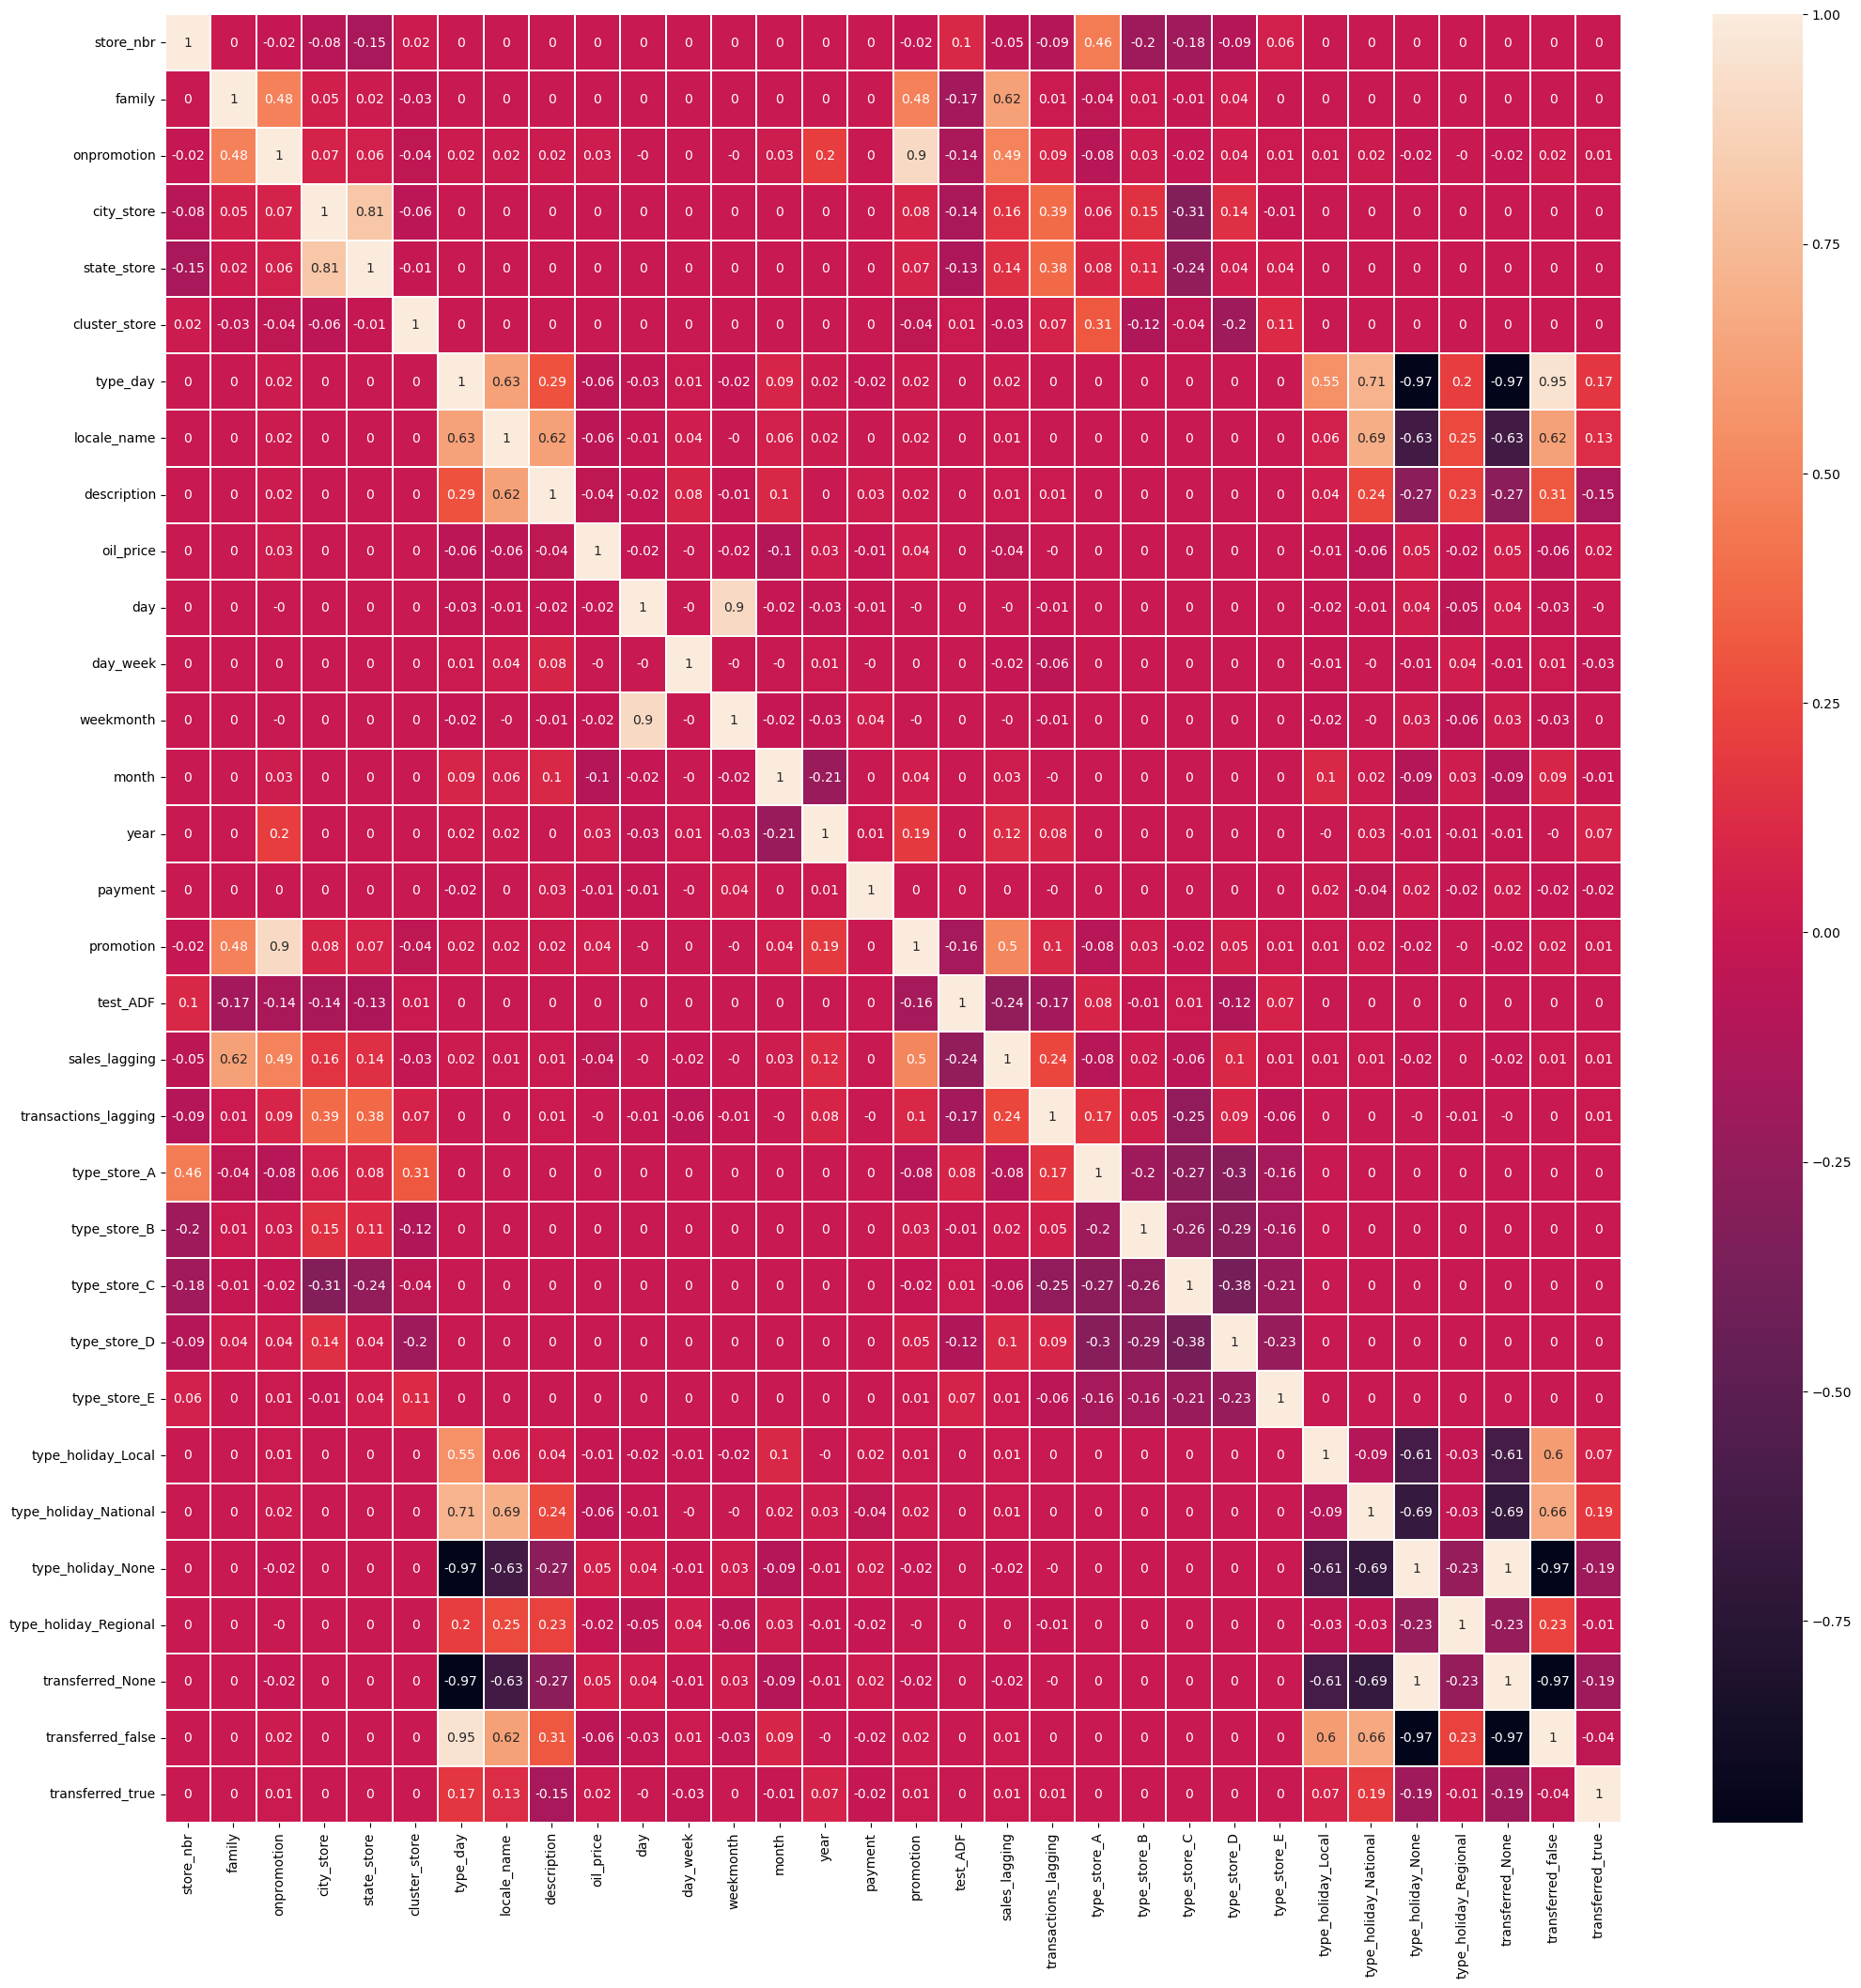

In [ ]:
fig, axes = plt.subplots(1, figsize=(25,25))
kendall_matrix = np.round(df_NSTC.corr(method='kendall'),2)
fig = sns.heatmap(kendall_matrix, annot=True,linewidths=.1)

Analisando o gráfico de correlação nota-se que as mesmas variáveis do dataset estacionário apresentaram valor de correlação acima de 0.7. 

Portanto as mesmas variáveis serão removidas neste dataset na aplicação do modelo de machine learning.

# **Training Model**

Para o treino do modelo será utilizado o modelo de regressão 'LightGBM Regressor', onde será aplicado o cross-validation e o tunning dos hiperparâmetros para a obtenção do melhor resultado da métrica RMSLE.

Neste caso será utilizado como target a variável 'sales' em formato log, por ter obtido um melhor desempenho. 

In [72]:
# data for Stationary Time-series
Y_ST = np.log(df_ST['sales']+1)
Y_ST.reset_index(inplace = True, drop = True)
X_ST = df_ST.drop(['sales','test_ADF'], axis = 1).copy()
idx_ST = df_ST.index
X_ST.reset_index(inplace = True, drop = True)
X_tST = X_ST.iloc[:-c_ST]
Y_tST = Y_ST.iloc[:-c_ST]

X_vST = X_ST.iloc[-c_ST:]
Y_vST = Y_ST.iloc[-c_ST:]

# data for Non Stationary Time-series
Y_NST = np.log(df_NST['sales']+1)
Y_NST.reset_index(inplace = True, drop = True)
X_NST = df_NST.drop(['sales','test_ADF'], axis = 1).copy()
idx_NST = df_NST.index
X_NST.reset_index(inplace = True, drop = True)
X_tNST = X_NST.iloc[:-c_NST]
Y_tNST = Y_NST.iloc[:-c_NST]

X_vNST = X_NST.iloc[-c_NST:]
Y_vNST = Y_NST.iloc[-c_NST:]


# Traning Stationary Time-series

In [73]:
def Objective_Reg(trial):
    
    LGBM__n_estimators = trial.suggest_int('LGBM__n_estimators', 100, 500)
    LGBM__max_depth = trial.suggest_int('LGBM__max_depth', -1, 250)
    LGBM__num_leaves = trial.suggest_int('LGBM__num_leaves', 100, 1000)
    LGBM__colsample_bytree = trial.suggest_float('LGBM__colsample_bytree', 0.5, 1, step = 0.01)
    LGBM__reg_alpha = trial.suggest_float('LGBM__reg_alpha', 0, 2, step=0.01)
    
    
    params = {
        'LGBM__n_estimators' : LGBM__n_estimators,
        'LGBM__max_depth' : LGBM__max_depth,
        'LGBM__num_leaves' : LGBM__num_leaves,
        'LGBM__colsample_bytree' : LGBM__colsample_bytree,
        'LGBM__reg_alpha' : LGBM__reg_alpha,
    }
    
    #_____ Training Model_________________###
    rmsle_v = []
    for i, (tr, ts) in enumerate(tscv.split(X_tST)):
        X_t, Y_t = X_tST.iloc[tr],Y_tST.iloc[tr]
        X_v,Y_v = X_tST.iloc[ts],Y_tST.iloc[ts]

        feat = ['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred']
        drop_list = ['state_store', 'weekmonth', 'type_holiday_National', 'type_holiday_None', 'transferred_None', 'transferred_false', 'promotion'] 
        cardinality = X_t[feat].nunique()
        low_card = cardinality[(cardinality<=5) == True].index.tolist()
        high_card = cardinality[(cardinality>5) == True].index.tolist()

        onehot = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
        JSE_encoder = JamesSteinEncoder()

        
        X_t = encoder_features(X_t, Y_t, feat, drop_list, onehot, JSE_encoder, low_card, high_card, 1)

        X_v = encoder_features(X_v, Y_v, feat, drop_list, onehot, JSE_encoder, low_card, high_card, 0)
        model = model_Reg.set_params(**params)
        model.fit(X_t,Y_t)

        pred_val = np.exp(model.predict(X_v)) - 1    
        pred_val[pred_val<0] = 0
        
        y_val = np.exp(Y_v) - 1

        aux3 = mean_squared_log_error(y_val, pred_val, squared = False)  
        rmsle_v.append(aux3)
    
    return np.round(np.mean(rmsle_v),decimals = 4)

In [74]:
tscv = TimeSeriesSplit(n_splits=5, test_size = c_ST)
model_Reg = Pipeline([('LGBM',ltb.LGBMRegressor(random_state=0, verbosity = -1))])
study_Reg = optuna.create_study(directions = ["minimize"])
study_Reg.optimize(Objective_Reg, n_trials = 20, show_progress_bar = True)

[I 2023-07-17 09:40:24,266] A new study created in memory with name: no-name-0017c58d-ff51-44d9-9ba9-85e4d1af806a
C:\Users\Pichau\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-07-17 09:43:09,534] Trial 0 finished with value: 0.4327 and parameters: {'LGBM__n_estimators': 333, 'LGBM__max_depth': 206, 'LGBM__num_leaves': 528, 'LGBM__colsample_bytree': 0.98, 'LGBM__reg_alpha': 0.74}. Best is trial 0 with value: 0.4327.
[I 2023-07-17 09:44:28,574] Trial 1 finished with value: 0.4537 and parameters: {'LGBM__n_estimators': 200, 'LGBM__max_depth': 108, 'LGBM__num_leaves': 107, 'LGBM__colsample_bytree': 0.99, 'LGBM__reg_alpha': 1.09}. Best is trial 0 with value: 0.4327.
[I 2023-07-17 09:48:43,155] Trial 2 finished with value: 0.4353 and parameters: {'LGBM__n_estimators': 409, 'LGBM__max_depth': 242, 'LGBM__num_leaves': 930, 'LGBM__colsample_bytree': 0.74, 'LGBM__reg_alpha': 0.14}. Best is trial 0 with value: 0.4327.
[I 2023-07-17 09:50:46,479] Trial 3 finished with value: 0.4392 and parameters: {'LGBM__n_estimators': 139, 'LGBM__max_depth': 12, 'LGBM__num_leaves': 669, 'LGBM__colsample_bytree': 0.81, 'LGBM__reg_alpha': 1.41}. Best is trial 0 with value: 0.432

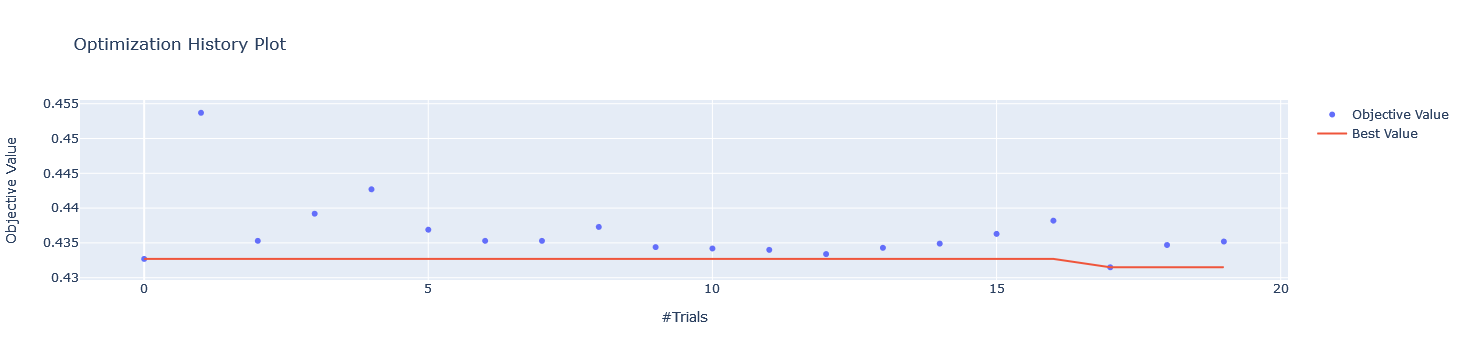

In [75]:
plot_optimization_history(study_Reg)

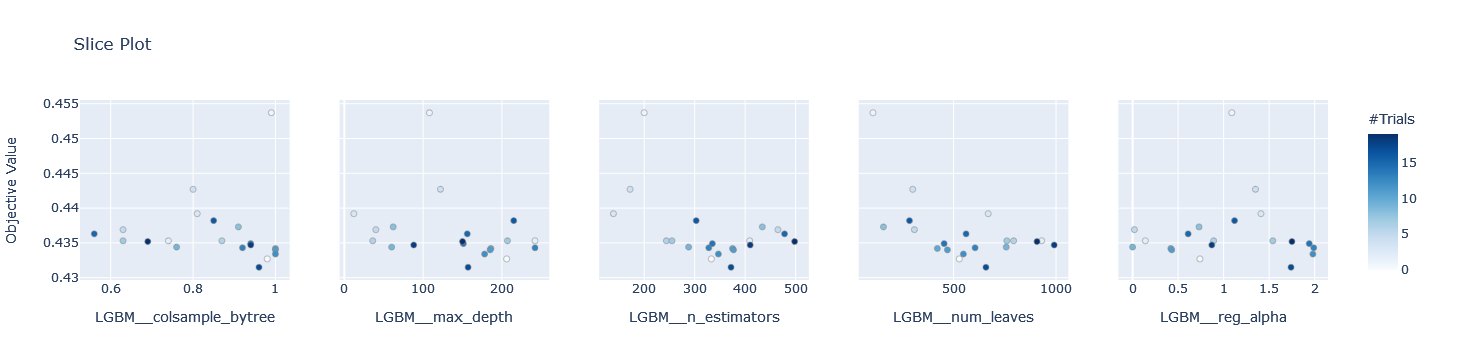

In [76]:
plot_slice(study_Reg)

In [77]:
study_Reg.best_params

{'LGBM__n_estimators': 372,
 'LGBM__max_depth': 157,
 'LGBM__num_leaves': 658,
 'LGBM__colsample_bytree': 0.96,
 'LGBM__reg_alpha': 1.74}

In [78]:
model_final = Pipeline([('LGBM',ltb.LGBMRegressor(random_state=0))])
model1 = model_final.set_params(**study_Reg.best_params)

feat = ['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred']
drop_list = ['state_store', 'weekmonth', 'type_holiday_National', 'type_holiday_None', 'transferred_None', 'transferred_false', 'promotion']

cardinality = X_ST[feat].nunique()
low_card1 = cardinality[(cardinality<=5) == True].index.tolist()
high_card1 = cardinality[(cardinality>5) == True].index.tolist()

# Conding train data
onehot1 = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
JSE_encoder1 = JamesSteinEncoder()

Xi = X_tST.reset_index(drop = True)
Yi = Y_tST.reset_index(drop = True)
XF = encoder_features(Xi, Yi, feat, drop_list, onehot1, JSE_encoder1,low_card1, high_card1, 1)

Xv = X_vST.reset_index(drop = True)
Yv = Y_vST.reset_index(drop = True)
XV = encoder_features(Xv, Yv, feat, drop_list, onehot1, JSE_encoder1, low_card1, high_card1, 0)

model1.fit(XF,Yi)
ypred = model1.predict(XV)
pred1 = np.exp(ypred)-1 
pred1[pred1<0] = 0

y1 = np.exp(Yv) - 1


rmsle_t = mean_squared_log_error(y1, pred1, squared = False)
print("RMSLE validation with all data: {:.5f}".format(rmsle_t))

RMSLE validation with all data: 0.44081


# Traning Non Stationary Time-series

In [79]:
def Objective_Reg2(trial):
    
    LGBM__n_estimators = trial.suggest_int('LGBM__n_estimators', 30, 600)
    LGBM__max_depth = trial.suggest_int('LGBM__max_depth', 10, 400)
    LGBM__num_leaves = trial.suggest_int('LGBM__num_leaves', 150, 400)
    LGBM__colsample_bytree = trial.suggest_float('LGBM__colsample_bytree', 0.5, 1, step = 0.01)
    LGBM__reg_alpha = trial.suggest_float('LGBM__reg_alpha', 0, 10, step=0.01)
    
    
    params = {
        'LGBM__n_estimators' : LGBM__n_estimators,
        'LGBM__max_depth' : LGBM__max_depth,
        'LGBM__num_leaves' : LGBM__num_leaves,
        'LGBM__colsample_bytree' : LGBM__colsample_bytree,
        'LGBM__reg_alpha' : LGBM__reg_alpha,
    }
    
    #_____ Training Model_________________###
    rmsle_v = []
    for i, (tr, ts) in enumerate(tscv.split(X_tNST)):
        X_t, Y_t = X_tNST.iloc[tr],Y_tNST.iloc[tr]
        X_v,Y_v = X_tNST.iloc[ts],Y_tNST.iloc[ts]

        feat = ['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred']
        drop_list = ['state_store', 'weekmonth', 'type_holiday_National', 'type_holiday_None', 'transferred_None', 'transferred_false', 'promotion'] 
        cardinality = X_t[feat].nunique()
        low_card = cardinality[(cardinality<=5) == True].index.tolist()
        high_card = cardinality[(cardinality>5) == True].index.tolist()

        onehot = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
        JSE_encoder = JamesSteinEncoder()
        X_t = encoder_features(X_t, Y_t, feat, drop_list, onehot, JSE_encoder, low_card, high_card, 1)

        X_v = encoder_features(X_v, Y_v, feat, drop_list, onehot, JSE_encoder, low_card, high_card, 0)
        
        model = model_Reg.set_params(**params)
        model.fit(X_t,Y_t)

        pred_val = np.exp(model.predict(X_v)) - 1
        pred_val[pred_val<0] = 0

        y_val = np.exp(Y_v) - 1
        
        aux3 = mean_squared_log_error(y_val, pred_val, squared = False)  
        rmsle_v.append(aux3)
    
    return np.round(np.mean(rmsle_v),decimals = 4)

In [80]:
tscv = TimeSeriesSplit(n_splits=5, test_size = c_NST)
model_Reg = Pipeline([('LGBM',ltb.LGBMRegressor(random_state=0, verbosity = -1))])
study_Reg2 = optuna.create_study(directions = ["minimize"])
study_Reg2.optimize(Objective_Reg2, n_trials = 30, show_progress_bar = True)

[I 2023-07-17 10:38:18,456] A new study created in memory with name: no-name-89cfcb8e-0d0a-41cb-baad-bf3652c0cda5
C:\Users\Pichau\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-07-17 10:38:46,507] Trial 0 finished with value: 0.4907 and parameters: {'LGBM__n_estimators': 52, 'LGBM__max_depth': 283, 'LGBM__num_leaves': 318, 'LGBM__colsample_bytree': 0.53, 'LGBM__reg_alpha': 5.95}. Best is trial 0 with value: 0.4907.
[I 2023-07-17 10:40:38,176] Trial 1 finished with value: 0.3998 and parameters: {'LGBM__n_estimators': 483, 'LGBM__max_depth': 196, 'LGBM__num_leaves': 376, 'LGBM__colsample_bytree': 0.99, 'LGBM__reg_alpha': 9.73}. Best is trial 1 with value: 0.3998.
[I 2023-07-17 10:41:08,842] Trial 2 finished with value: 0.4285 and parameters: {'LGBM__n_estimators': 73, 'LGBM__max_depth': 209, 'LGBM__num_leaves': 281, 'LGBM__colsample_bytree': 0.95, 'LGBM__reg_alpha': 4.28}. Best is trial 1 with value: 0.3998.
[I 2023-07-17 10:42:23,685] Trial 3 finished with value: 0.417 and parameters: {'LGBM__n_estimators': 420, 'LGBM__max_depth': 107, 'LGBM__num_leaves': 235, 'LGBM__colsample_bytree': 0.5700000000000001, 'LGBM__reg_alpha': 0.38}. Best is trial 1 with 

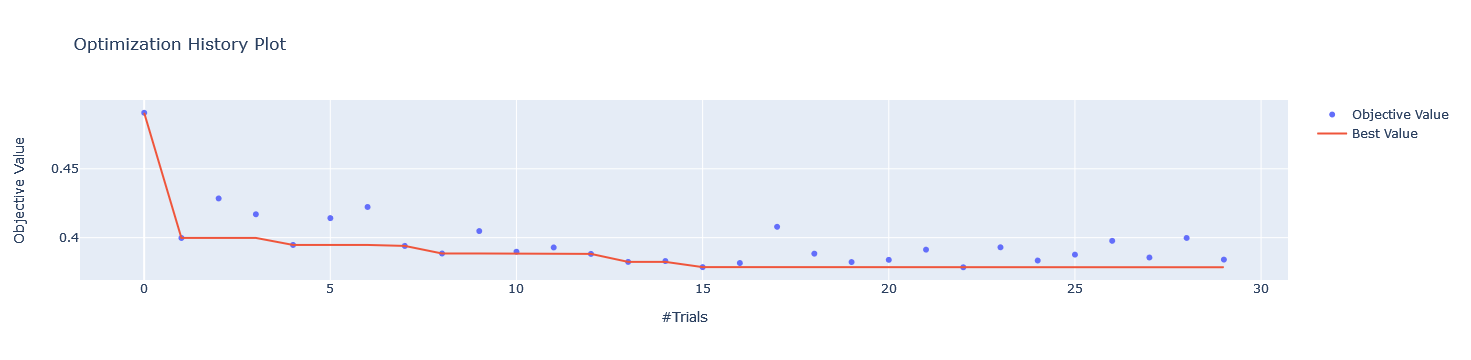

In [81]:
plot_optimization_history(study_Reg2)

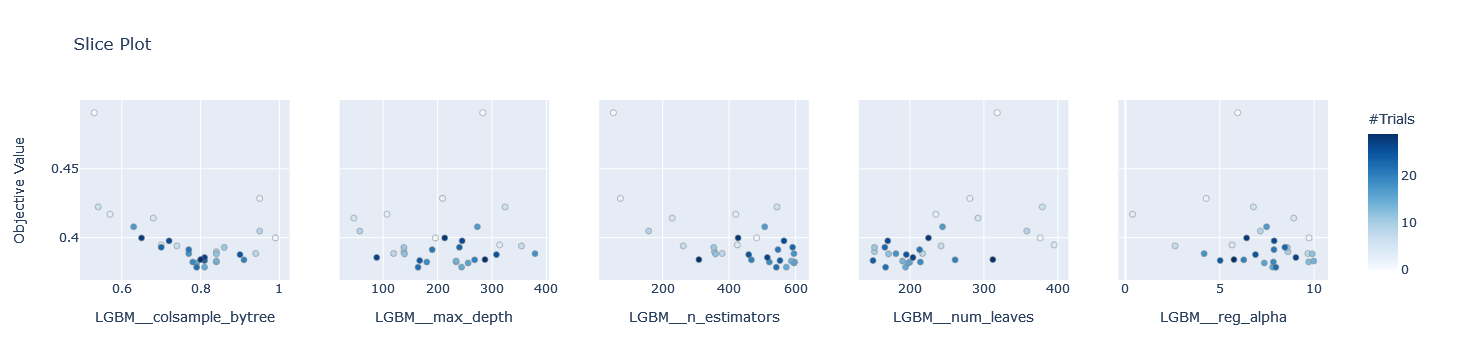

In [82]:
plot_slice(study_Reg2)

In [83]:
study_Reg2.best_params

{'LGBM__n_estimators': 542,
 'LGBM__max_depth': 164,
 'LGBM__num_leaves': 167,
 'LGBM__colsample_bytree': 0.79,
 'LGBM__reg_alpha': 7.97}

In [84]:
model_final2 = Pipeline([('LGBM',ltb.LGBMRegressor(random_state=0))])
model2 = model_final2.set_params(**study_Reg2.best_params)

feat = ['store_nbr','family', 'city_store', 'state_store', 'type_store', 'type_day', 'type_holiday', 'locale_name', 'description', 'transferred']
drop_list = ['state_store', 'weekmonth', 'type_holiday_National', 'type_holiday_None', 'transferred_None', 'transferred_false', 'promotion']

cardinality = X_tNST[feat].nunique()
low_card2 = cardinality[(cardinality<=5) == True].index.tolist()
high_card2 = cardinality[(cardinality>5) == True].index.tolist()

# Conding train data
onehot2 = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
JSE_encoder2 = JamesSteinEncoder()

Xi = X_tNST.reset_index(drop = True)
Yi = Y_tNST.reset_index(drop = True)
XF = encoder_features(Xi, Yi, feat, drop_list, onehot2, JSE_encoder2, low_card2, high_card2, 1)

Xv = X_vNST.reset_index(drop = True)
Yv = Y_vNST.reset_index(drop = True)
XV = encoder_features(Xv, Yv, feat, drop_list, onehot2, JSE_encoder2, low_card2, high_card2, 0)
model2.fit(XF,Yi)

ypred = model2.predict(XV)
pred2 = np.exp(ypred)-1   
pred2[pred2<0] = 0

y2 = np.exp(Yv) - 1

rmsle_t = mean_squared_log_error(y2, pred2, squared = False)
print("RMSLE validation with all data: {:.5f}".format(rmsle_t))

RMSLE validation with all data: 0.38046


In [85]:
y1.index = Y_vST.index
y2.index = Y_vNST.index
y_total = pd.concat([y1, y2]).sort_index() 

p1 = pd.DataFrame(data = pred1, index = Y_vST.index)
p2 = pd.DataFrame(data = pred2, index = Y_vNST.index)
pred_total = pd.concat([p1, p2]).sort_index()

In [86]:
rmsle_t = mean_squared_log_error(y_total, pred_total, squared = False)
print("RMSLE validation with 2 models: {:.5f}".format(rmsle_t))

RMSLE validation with 2 models: 0.42455


Após o treinamento dos dois modelos diferentes obteve-se um valor de RMSLE de 0.42455 para os dados de validação. 

Mas será que este valor é um valor aceitável? Para verificar isto era necessário saber o método de estimativa de estoque aplicado nestas lojas, mas como não temos essa informação será feito uma aproximação da média de venda de 16 dias, separando esta métrica por família e loja e utilizando como base os ultimos 3 meses para o seu cálculo, e realizando um acréscimo de vendas de 0%, 5% e 10%. 

Após isto será feito uma comparação com o valor real vendido nos ultimos 16 comparando com o predito pelo modelo e com o método simplificado descrito anteriormente.

In [89]:
df_comparative =train_merged[['store_nbr','family','sales','date']].copy()
df_comparative.tail(5)

store_nbr                      family     sales       date
3054343          9                     POULTRY   438.133 2017-08-15
3054344          9              PREPARED FOODS   154.553 2017-08-15
3054345          9                     PRODUCE  2419.729 2017-08-15
3054346          9  SCHOOL AND OFFICE SUPPLIES   121.000 2017-08-15
3054347          9                     SEAFOOD    16.000 2017-08-15

No caso em questão só serão utilizados os últimos 16 para validação e os 3 meses anteriores a este período para criar a estimativa de vendas, portanto os dados anteriores a esse período serão removidos. após isto será criado uma nova categoria para separar esses períodos, facilitando os cálculos futuros. 

In [116]:
df_comp = df_comparative[df_comparative['date'] > '2017-04-25'].copy()
df_comp['marker_16days'] = 0
df_comp.loc[df_comp[df_comp['date'] > '2017-05-11'].index,'marker_16days'] = 1
df_comp.loc[df_comp[df_comp['date'] > '2017-05-27'].index,'marker_16days'] = 2
df_comp.loc[df_comp[df_comp['date'] > '2017-06-12'].index,'marker_16days'] = 3
df_comp.loc[df_comp[df_comp['date'] > '2017-06-28'].index,'marker_16days'] = 4
df_comp.loc[df_comp[df_comp['date'] > '2017-07-14'].index,'marker_16days'] = 5
df_comp.loc[df_comp[df_comp['date'] > '2017-07-30'].index,'marker_16days'] = 6

In [119]:
sales_16d = df_comp.groupby(['marker_16days','store_nbr','family']).agg(sum_sales = ('sales', sum)) 
sales_16d.reset_index(inplace = True)
sales_16d

marker_16days  store_nbr                      family     sum_sales
0                  0          1                  AUTOMOTIVE     60.000000
1                  0          1                   BABY CARE      0.000000
2                  0          1                      BEAUTY     49.000000
3                  0          1                   BEVERAGES  32940.000000
4                  0          1                       BOOKS      9.000000
...              ...        ...                         ...           ...
12469              6         54                     POULTRY   1088.924992
12470              6         54              PREPARED FOODS   1440.000000
12471              6         54                     PRODUCE  10984.987000
12472              6         54  SCHOOL AND OFFICE SUPPLIES      0.000000
12473              6         54                     SEAFOOD     42.000000

[12474 rows x 4 columns]

In [121]:
df_validation = sales_16d[sales_16d['marker_16days'] == 6].copy()
df_validation.drop(['marker_16days'], axis = 1)

In [132]:
mean_sale = sales_16d[sales_16d['marker_16days'] <5]
mean_sales = mean_sale.groupby(['store_nbr','family']).agg(mean_sales = ('sum_sales', 'mean')) 
mean_sales.reset_index(inplace = True)
mean_sales

store_nbr                      family    mean_sales
0             1                  AUTOMOTIVE     67.200000
1             1                   BABY CARE      0.000000
2             1                      BEAUTY     56.200000
3             1                   BEVERAGES  36004.400000
4             1                       BOOKS      7.000000
...         ...                         ...           ...
1777         54                     POULTRY   1053.981600
1778         54              PREPARED FOODS   1496.000000
1779         54                     PRODUCE  11167.399606
1780         54  SCHOOL AND OFFICE SUPPLIES     38.000000
1781         54                     SEAFOOD     47.200000

[1782 rows x 3 columns]

In [136]:
mean_sales['mean_sales_5'] = mean_sales['mean_sales']*1.05
mean_sales['mean_sales_10'] = mean_sales['mean_sales']*1.1
mean_sales['sales_target'] = df_validation['sum_sales'].values

In [165]:
X_pred =  pd.concat([X_vST[['store_nbr','family']], X_vNST[['store_nbr','family']]]).sort_index()
X_pred['sales'] = pred_total
mean_pred = X_pred.groupby(['store_nbr','family']).agg(sum_pred = ('sales', 'sum')) 
mean_pred.reset_index(inplace = True)
mean_pred

store_nbr                      family      sum_pred
0             1                  AUTOMOTIVE     59.612825
1             1                   BABY CARE      0.731144
2             1                      BEAUTY     50.041197
3             1                   BEVERAGES  33018.317765
4             1                       BOOKS      2.550712
...         ...                         ...           ...
1777         54                     POULTRY   1016.383434
1778         54              PREPARED FOODS   1224.375479
1779         54                     PRODUCE  11468.033252
1780         54  SCHOOL AND OFFICE SUPPLIES      0.549668
1781         54                     SEAFOOD     30.179633

[1782 rows x 3 columns]

In [166]:
mean_sales['predict'] = mean_pred['sum_pred']
mean_sales['diff_mean_sales_0'] = mean_sales['mean_sales'] - mean_sales['sales_target'] 
mean_sales['diff_mean_sales_5'] = mean_sales['mean_sales_5'] - mean_sales['sales_target'] 
mean_sales['diff_mean_sales_10'] = mean_sales['mean_sales_10'] - mean_sales['sales_target'] 
mean_sales['diff_pred_sales'] =  mean_sales['predict'] - mean_sales['sales_target']
diff

In [177]:
mean_sales.head(5)

store_nbr      family  mean_sales  mean_sales_5  mean_sales_10  \
0          1  AUTOMOTIVE        67.2         70.56          73.92   
1          1   BABY CARE         0.0          0.00           0.00   
2          1      BEAUTY        56.2         59.01          61.82   
3          1   BEVERAGES     36004.4      37804.62       39604.84   
4          1       BOOKS         7.0          7.35           7.70   

   sales_target       predict  diff_mean_sales_0  diff_mean_sales_5  \
0          79.0     59.612825              -11.8              -8.44   
1           0.0      0.731144                0.0               0.00   
2          62.0     50.041197               -5.8              -2.99   
3       32066.0  33018.317765             3938.4            5738.62   
4           1.0      2.550712                6.0               6.35   

   diff_mean_sales_10  diff_pred_sales  
0               -5.08       -19.387175  
1                0.00         0.731144  
2               -0.18       -11.958803  
3             7538.84       952.317765  
4                6.70         1.550712

In [232]:
diff = pd.DataFrame(np.zeros([len(mean_sales)*4,4]), columns = ['diff','groups','store_nbr','family'])
idx0 = 0
idx1 = len(mean_sales)
diff['diff'] = mean_sales['diff_mean_sales_0']
diff.loc[range(idx0,idx1),'groups'] = 'mean sales 0%'
diff.loc[range(idx0,idx1),'store_nbr'] =  mean_sales['store_nbr']
diff.loc[range(idx0,idx1),'family'] = mean_sales['family']

idx0 = idx1
idx1 = idx1+len(mean_sales)
diff.loc[range(idx0,idx1),'diff'] = mean_sales['diff_mean_sales_5'].values
diff.loc[range(idx0,idx1),'groups'] = 'mean sales 5%'
diff.loc[range(idx0,idx1),'store_nbr'] =  mean_sales['store_nbr'].values
diff.loc[range(idx0,idx1),'family'] = mean_sales['family'].values

idx0 = idx1
idx1 = idx1+len(mean_sales)
diff.loc[range(idx0,idx1),'diff'] = mean_sales['diff_mean_sales_10'].values
diff.loc[range(idx0,idx1),'groups'] = 'mean sales 10%'
diff.loc[range(idx0,idx1),'store_nbr'] =  mean_sales['store_nbr'].values
diff.loc[range(idx0,idx1),'family'] = mean_sales['family'].values

idx0 = idx1
idx1 = idx1+len(mean_sales)
diff.loc[range(idx0,idx1),'diff'] = mean_sales['diff_pred_sales'].values
diff.loc[range(idx0,idx1),'groups'] = 'predict'
diff.loc[range(idx0,idx1),'store_nbr'] =  mean_sales['store_nbr'].values
diff.loc[range(idx0,idx1),'family'] = mean_sales['family'].values

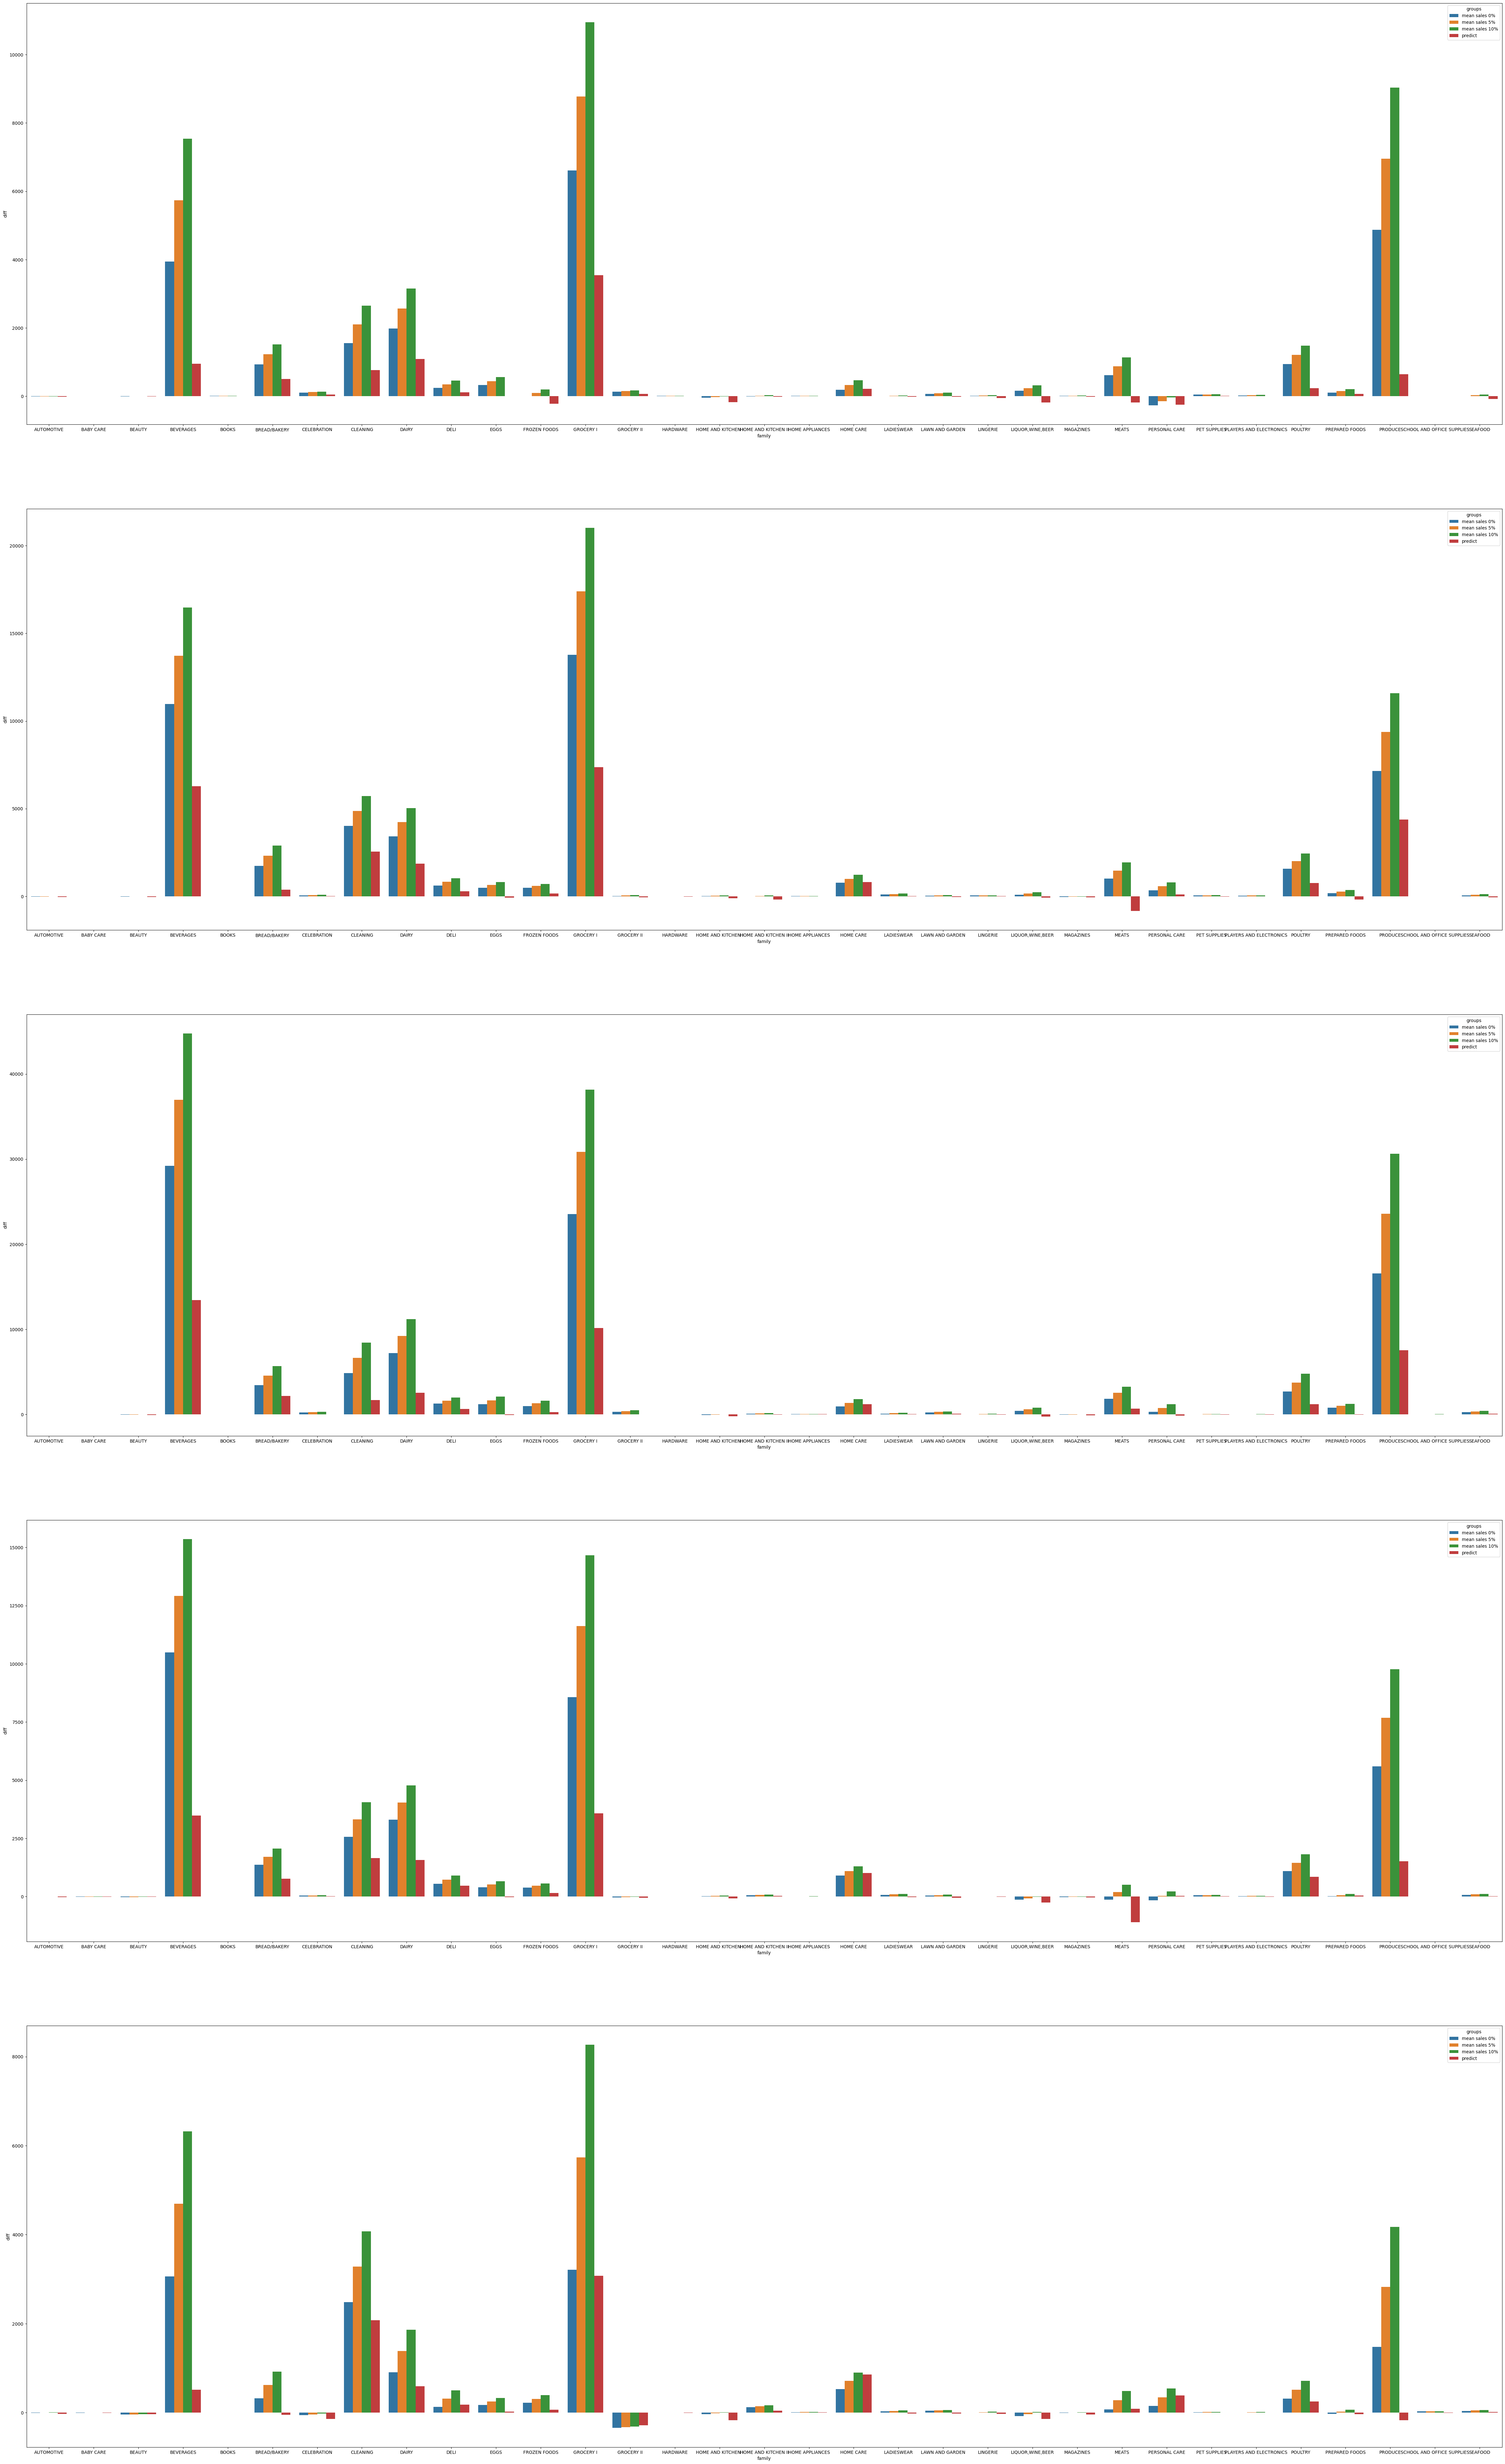

In [273]:
name_store = diff['store_nbr'].unique()
fig, axs = plt.subplots(5,1,figsize=(60,100))

for i in range(0,5):
    sns.barplot(x='family', y='diff',hue = 'groups', data=diff[diff['store_nbr'] == name_store[i]], ax = axs[i])

Observando os gráficos de diferença de vendas por família para os 5 primeiro stores tem-se:
- O valor de predict se mantém como a menor diferença para a maioria das famílias.
- produtos como 'BEVERAGES',  'CLEANING',  'DAIRY', 'GROCERY I','HOME CARE'  e 'PRODUCE' mantém uma maior diferença em todos os stores analisados, seja pelo previsto pelo modelo quando pelas aproximações. Isto pode ser um ponto de melhoria do modelo, sendo acrescentado um terceiro algoritmo para prever somente esses produtos.
- Em alguns casos o produto 'MEAT' teve um erro maior no predict do que pelas aproximações.

O ideal, neste caso, seria realizar o plot dos outros 49 stores  para obtenção de mais insights sobre o desempenho do modelo, porém a ideia da análise seria semelhante, identificando os produtos com maiores erros e/ou stores com maior diferença de vendas para posteriormente refinar o treinamento do modelo ou até separar em mais modelos para realizar o treinamento.

Neste caso foi averiguado que o modelo possui um erro menor do que aproximações simplificadas para obtenção de itens vendidos, comprovando que um valor aproximado de RMSLE igual à 0.42 é um valor satisfatório.

Vale ressaltar que o modelo foi comparado com um método muito simplicado que pode ser ou não aplicado na vida real para a predição de estoque, além de que a comparação não foi feita em períodos de feriados importantes, que acabam resultando em mais vendas (estes períodos são os momentos em que um algoritmo de machine learning mostraria uma maior eficácia do que estimativas simplificadas de estoque).

Visando melhorias futuras podem ser realizados os seguintes procedimentos:
- Separar itens de maior demanda e menor demanda e treinar modelos diferentes para cada um dos casos.
- Criar mais variáveis lagging, como por exemplo a diferença de vendas entre 'sales_lagging' e 16 dias de 'sales_lagging', e verificar sua eficácia.
- Verificar a importância das features utilizadas e realizar remoção das variáveis de menor impacto para otimização do modelo.
- Verificar se famílias de produtos com um maior número de 'sales' igual a zero impactam no treinamento/performance do modelo.